> this works: https://github.com/frietz58/sac_blog_stuff/blob/main/df_vis.ipynb

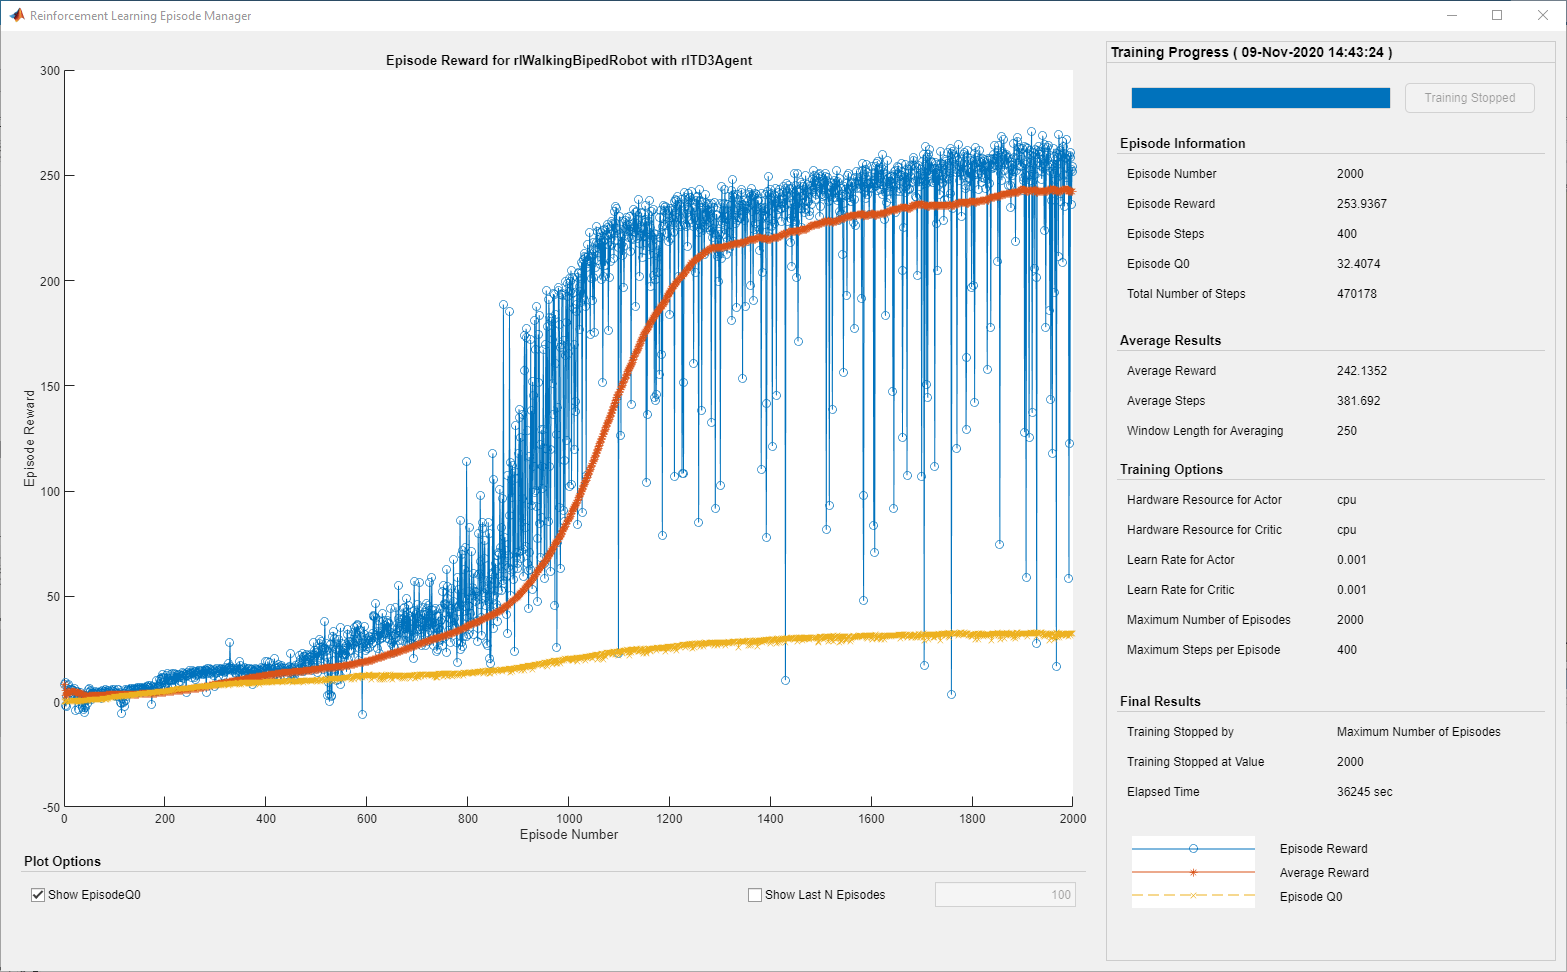

> this appeared to solve it, but soemthing is off: https://www.mathworks.com/help/deeplearning/ug/train-biped-robot-to-walk-using-reinforcement-learning-agents.html

In [1]:
# https://github.com/nikhilbarhate99/TD3-PyTorch-BipedalWalker-v2/blob/master/train.py

In [2]:
# 1  https://github.com/nextgrid/deep-learning-labs-openAI/tree/main/BipedalWalker-v3

In [3]:
# plotting advanced.......... https://github.com/NickKaparinos/OpenAI-Gym-Projects/tree/master/Box2D/BipedalWalker

In [4]:
# really good for diagrams and understanding...https://pylessons.com/BipedalWalker-v3-PPO/

In [5]:
# understanding............. https://pylessons.com/BipedalWalker-v3-PPO/

In [6]:
# version............................. pure research into advanced visualization

In [7]:
# https://pylessons.com/LunarLander-v2-PPO/

It is aimed at making full use of a computer's GPU and multicore CPU, by combining a net thread for the gpu, and multiple experience threads for the cpu.

> https://github.com/openai/gym/blob/master/gym/envs/box2d/bipedal_walker.py

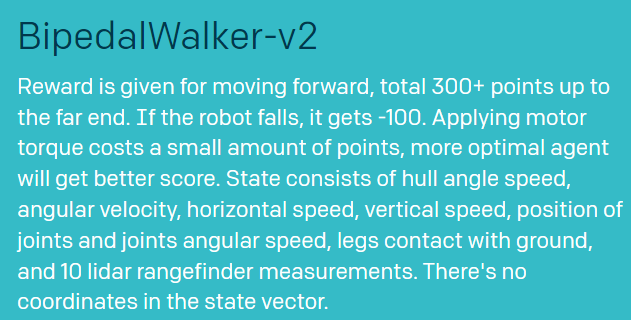

In [8]:
# This is simple 4-joints walker robot environment.
#
# There are two versions:
#
# - Normal, with slightly uneven terrain.
#
# - Hardcore with ladders, stumps, pitfalls.
#
# Reward is given for moving forward, total 300+ points up to the far end. If the robot falls,
# it gets -100. Applying motor torque costs a small amount of points, more optimal agent
# will get better score.
#
# Heuristic is provided for testing, it's also useful to get demonstrations to
# learn from. To run heuristic:
#
# python gym/envs/box2d/bipedal_walker.py
#
# State consists of hull angle speed, angular velocity, horizontal speed, vertical speed,
# position of joints and joints angular speed, legs contact with ground, and 10 lidar
# rangefinder measurements to help to deal with the hardcore version. There's no coordinates
# in the state vector. Lidar is less useful in normal version, but it works.
#
# To solve the game you need to get 300 points in 1600 time steps.
#
# To solve hardcore version you need 300 points in 2000 time steps.
#
# Created by Oleg Klimov. Licensed on the same terms as the rest of OpenAI Gym.

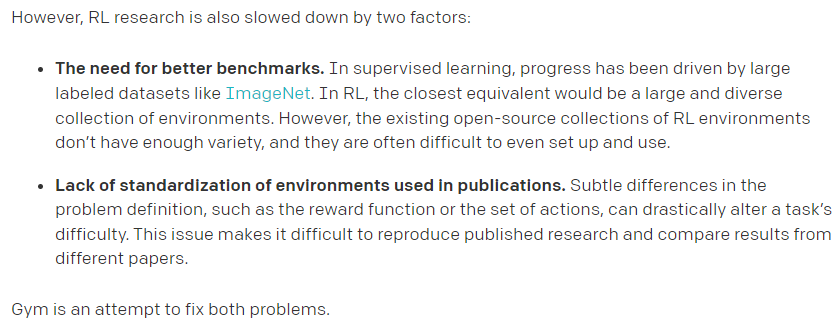

In [9]:
version = "REPLACE_PACKAGE_VERSION"

In [10]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Reinforcement Learning


## Assignment 3 Part 2: Bipedal Walker Problem - Twin Delayed DDPG (TD3)

In this assignment, we will solve the "BipedalWalker-v3" task from the OpenAI Gym using Twin Delayed DDPG (TD3) algorithm.

### Problem Desciption

In this environment, a 2D bipedal walker has to learn a policy to walk without falling over. The total reward calculation is based on the total distance travelled by the agent. The episode ends when the walker touches the ground or it reaches the far right side of the environment.

![Work Area](assets/bipedal_walker.gif)


### Formulation

- *State* $s$: 
    The state consists of 24 observations as follows:
    Num   | Observation                |  Min   |   Max  | Mean
    ------|----------------------------|--------|--------|------   
    0     | hull_angle                 |  0     | 2$\pi$ |  0.5
    1     | hull_angularVelocity       |  -inf  |  +inf  |  -
    2     | vel_x                      |  -1    |  +1    |  -
    3     |  vel_y                     |  -1    |  +1    |  -
    4     | hip_joint_1_angle          |  -inf  |  +inf  |  -
    5     | hip_joint_1_speed          |  -inf  |  +inf  |  -
    6     | knee_joint_1_angle         |  -inf  |  +inf  |  -
    7     | knee_joint_1_speed         |  -inf  |  +inf  |  -
    8     | leg_1_ground_contact_flag  |  0     |  1     |  -
    9     | hip_joint_2_angle          |  -inf  |  +inf  |  -
    10    | hip_joint_2_speed          |  -inf  |  +inf  |  -
    11    | knee_joint_2_angle         |  -inf  |  +inf  |  -
    12    | knee_joint_2_speed         |  -inf  |  +inf  |  -
    13    | leg_2_ground_contact_flag  |  0     |  1     |  -
    14-23 | 10 lidar readings          |  -inf  |  +inf  |  -


- *Action $a$*:
    The continuous action has four dimensions:
    Num | Name                        | Min  | Max  
    ----|-----------------------------|------|------
    0   | Hip_1 (Torque / Velocity)   |  -1  | +1
    1   | Knee_1 (Torque / Velocity)  |  -1  | +1
    2   | Hip_2 (Torque / Velocity)   |  -1  | +1
    3   | Knee_2 (Torque / Velocity)  |  -1  | +1


- *Reward $r(s,a)$*:
    
    Reward is given for moving forward, the walker can get 300+ points when reaching the far end. If the walker falls, it gets -100.
    

- Episode Termination

    An episode terminates when one of the following occurs:
  - The walker reaches the far right side of the environment.
  - The walker touches the ground.
  - Episode length is greater than 1600.


- *Objective*:
    
    To get an average reward of more than 270 over 50 consecutive trials (episodes).


In [11]:
# Import packages, set threads. Run this cell.
import os 
os.environ["MKL_NUM_THREADS"] = "2"
os.environ["NUMEXPR_NUM_THREADS"] = "2"
os.environ["OMP_NUM_THREADS"] = "2"
os.environ["OPENBLAS_NUM_THREADS"] = "2"
os.environ["BLIS_NUM_THREADS"] = "2"

import numpy as np
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque
import random
import torch.optim as optim
import matplotlib.pyplot as plt
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
import pickle

# display = Display(visible=False, size=(4, 3))
# _ = display.start()

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns

In [13]:
# !pip install torchinfo

In [14]:
# from torchinfo import summary

### Question
(7 points)

We will use the Twin Delayed DDPG (TD3) algorithm to solve the "BipedalWalker-v3" task.

Please complete the function ``train(self, cur_time_step, episode_time_step, state, action, reward, next_state, done)`` in the class ``TD3``. ``train(self, cur_time_step, episode_time_step, state, action, reward, next_state, done)`` will be called each step the agent interacts with the environment. The function collects samples and updates actor network and critic network using mini-batches of experience tuples. The input arguments are as follows:
- cur_time_step: current time step counting from the beginning, which is equal to the number of times the agent interacts with the environment
- episode_time_step: the time step counting from the current episode
- state: current state, a numpy array with shape (state_size,)
- action: current action, a numpy array with shape (action_size,)
- reward: reward obtained
- next_state: next state, a numpy array with shape (state_size,)
- done: ``True`` when the current episode ends, ``False`` otherwise
   
You can also add or revise classes and functions if you need.

**Note**: 
- The platform does not support GPU, so please use CPU.
- Please use the class ``Actor`` as your actor network and the class ``CriticQ`` as your critic network
- We have pre-trained an actor network and a critic network for you in order to reduce your training time.

**Recommended Hyperparameters**:
- Learning rate for the actor network: 1e-4
- Learning rate for the critic network: 1e-4
- Replay buffer capacity: 100000
- Batch size: 128
- Soft update step size for target networks: $\tau$=0.02

    Target networks are updated towards main networks according to:
    \begin{align}
        \theta_{\text{targ}} \leftarrow (1-\tau) \theta_{\text{targ}} + \tau \theta
    \end{align}

- Policy update period: 2

    Policy will be updated once every 2 updates of the Q-networks.
    
- Discount factor: 0.99
- Standard deviation for smoothing noise added to target policy: 0.2
- Limit for absolute value of target policy smoothing noise: 0.5
- Number of environment interactions that should elapse between gradient descent updates: 200

    Note: Regardless of how long you wait between updates, the ratio of env steps to gradient steps should be 1. For example, we update once every 200 environment interations and each update includes 200 gradient steps for Q-networks. 


In [15]:
# # -----------------------------------------
# # I am creating a couple utility functions:
# # -----------------------------------------

# def show_model_information(model):
    
#     # Print model's state_dict
    
#     print("--- Model's state_dict ---\n")
    
#     for param_tensor in model.state_dict():
        
#         print(param_tensor, "\t", model.state_dict()[param_tensor].size())
        
# def show_optimizer_information(optimizer):
    
#     # Print optimizer's state_dict
    
#     print("--- Optimizer's state_dict ---\n")
    
#     for var_name in optimizer.state_dict():
#         print(var_name, "\t", optimizer.state_dict()[var_name])

In [16]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [17]:

device


device(type='cuda')

In [18]:
"""
Some parameters
"""
state_size = 24  # state dimension
action_size = 4  # action dimension
fc_units = 256  # number of neurons in one fully connected hidden layer
action_upper_bound = 1  # action space upper bound
action_lower_bound = -1  # action space lower bound
actor_path = "assets/pretrained_actor.pth"  # The pre-trained actor network
critic_path = "assets/pretrained_critic.pth"  # The pre-trained critic network

"""
Structure of Actor Network.
"""
class Actor(nn.Module):
    def __init__(self):
        super().__init__()
        self.max_action = action_upper_bound
        self.fc1 = nn.Linear(state_size, fc_units)
        self.fc2 = nn.Linear(fc_units, fc_units)
        self.fc3 = nn.Linear(fc_units, action_size)

    def forward(self, state):
        """
        Build an actor (policy) network that maps states -> actions.
        Args:
            state: torch.Tensor with shape (batch_size, state_size)
        Returns:
            action: torch.Tensor with shape (batch_size, action_size)
        """
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        action = torch.tanh(self.fc3(x)) * self.max_action
        return action


"""
Structure of Critic Network.
"""
class CriticQ(nn.Module):
    def __init__(self):
        """
        Args:
            state_size: state dimension
            action_size: action dimension
            fc_units: number of neurons in one fully connected hidden layer
        """
        super().__init__()
        
        # Q-network 1 architecture
        self.l1 = nn.Linear(state_size + action_size, fc_units)
        self.l2 = nn.Linear(fc_units, fc_units)
        self.l3 = nn.Linear(fc_units, 1)

        # Q-network 2 architecture
        self.l4 = nn.Linear(state_size + action_size, fc_units)
        self.l5 = nn.Linear(fc_units, fc_units)
        self.l6 = nn.Linear(fc_units, 1)

    def forward(self, state, action):
        """
        Build a critic (value) network that maps state-action pairs -> Q-values.
        Args:
            state: torch.Tensor with shape (batch_size, state_size)
            action: torch.Tensor with shape (batch_size, action_size)
        Returns:
            Q_value_1: torch.Tensor with shape (batch_size, 1)
            Q_value_2: torch.Tensor with shape (batch_size, 1)
        """
        state_action = torch.cat([state, action], 1)
        
        x1 = F.relu(self.l1(state_action))
        x1 = F.relu(self.l2(x1))
        Q_value_1 = self.l3(x1)
        
        x2 = F.relu(self.l4(state_action))
        x2 = F.relu(self.l5(x2))
        Q_value_2 = self.l6(x2)
        
        return Q_value_1, Q_value_2

In [19]:
"""
Implementation of TD3 Algorithm
"""

class TD3:
    
    def __init__(self):
        
        
        
        
        # --- learning rate ---
        
        self.lr_actor = 1e-4  # learning rate for actor network
        
        self.lr_critic = 1e-4  # learning rate for critic network
        
        # this is pretty small, potentially I need to change this to 0.001 ???? 
        
        # small is good, but too small is not great 
        
        
        self.buffer_capacity = 100000  # replay buffer capacity
        
        self.batch_size = 100  # mini-batch size  IM changing this from 128 !!!!!!!!!!!!!!!!!!!
        
        # num of transitions sampled from replay buffer
        
        
        self.tau = 0.02  # soft update parameter
        
        # I THINK:  target policy update parameter (1-tau) is polyak = 0.995
        
        # Therefore a closer value might be   0.005 ? 
        
        
        
        
        self.policy_delay = 2  # policy will be updated once every policy_delay times for each update of the Q-networks.
        
        
        # --- gamma ---
        
        self.gamma = 0.99  # discount for future rewards
        
        
        
        
        # --- target noise --- 
        
        self.target_noise = 0.2  
        
        # standard deviation for smoothing noise added to target policy
        
        # target policy smoothing noise
        
        self.noise_clip = 0.5  
        
        # limit for absolute value of target policy smoothing noise.
        
        #   + / -   1   and then take into consideration the 0.5 
        
        
        
        
        #### i think this is already assumed:  policy_delay = 2            
        
        # delayed policy updates parameter
        
        
        
        
        
        self.update_every = 200  # number of env interactions that should elapse between updates of Q-networks.
        
        # Note: Regardless of how long you wait between updates, the ratio of env steps to gradient steps should be 1.
        
        self.state_size = state_size
        
        self.action_size = action_size
        
        
        
        # making it gpu compliant ! ! ! ! 
        
        self.device =   torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        
        
        self.action_upper_bound = action_upper_bound  # action space upper bound
        self.action_lower_bound = action_lower_bound  # action space lower bound
        
        self.create_actor()
        self.create_critic()
    
        self.act_opt = optim.Adam(self.actor.parameters(), lr=self.lr_actor)
        self.crt_opt = optim.Adam(self.critic.parameters(), lr=self.lr_critic)
        self.replay_memory_buffer = deque(maxlen=self.buffer_capacity)
        
        self.loss_fn = torch.nn.MSELoss()  # loss function # TOM ADDED THIS HIMSELF MANUALLY !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        
        
        
    def create_actor(self):
        self.actor = Actor().to(self.device)
        self.actor.load_state_dict(torch.load(actor_path))
        
        self.actor_target = Actor().to(self.device)
        self.actor_target.load_state_dict(self.actor.state_dict())

        
        
    def create_critic(self):
        
        self.critic = CriticQ().to(self.device)
        self.critic.load_state_dict(torch.load(critic_path))
        
        self.critic_target = CriticQ().to(self.device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        
        #  auto updates method of class... 
        
        
    
    def add_to_replay_memory(self, state, action, reward, next_state, done):
        """
        Add samples to replay memory
        Args:
            state: current state, a numpy array with shape (state_size,)
            action: current action, a numpy array with shape (action_size,)
            reward: reward obtained
            next_state: next state, a numpy array with shape (state_size,)
            done: True when the current episode ends, False otherwise
        """
        self.replay_memory_buffer.append((state, action, reward, next_state, done))

        
        
    def get_random_sample_from_replay_mem(self):
        """
        Random samples from replay memory without replacement
        Returns a self.batch_size length list of unique elements chosen from the replay buffer.
        Returns:
            random_sample: a list with len=self.batch_size,
                           where each element is a tuple (state, action, reward, next_state, done)
        """
        random_sample = random.sample(self.replay_memory_buffer, self.batch_size)
        return random_sample
    
    
    
    def soft_update_target(self, local_model, target_model):
        """
        Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Args:
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau*local_param.data + (1.0-self.tau)*target_param.data)
            
            
    # input is one tuple ? cur_time_step, episode_time_step, state, action, reward, next_state, done
    

    def train(self, cur_time_step, episode_time_step, state, action, reward, next_state, done):
        """
        Collect samples and update actor network and critic network using mini-batches of experience tuples.
        Args:
            cur_time_step: current time step counting from the beginning, 
                           which is equal to the number of times the agent interacts with the environment
                           
            episode_time_step: the time step counting from the current episode
            
            state: current state, a numpy array with shape (state_size,)
            action: current action, a numpy array with shape (action_size,)
            reward: reward obtained
            next_state: next state, a numpy array with shape (state_size,)
            done: True when the current episode ends, False otherwise
        """
        
        self.add_to_replay_memory(state, action, reward, next_state, done) 
        
        if len(self.replay_memory_buffer) < self.batch_size:
            return
        if cur_time_step % self.update_every != 0:
            return
        
        # Perform self.update_every times of updates of the critic networks and 
        # (self.update_every / policy_delay) times of updates of the actor network
        
        
        for it in range(self.update_every): 
            """
            state_batch: torch.Tensor with shape (self.batch_size, state_size), a mini-batch of current states
            action_batch: torch.Tensor with shape (self.batch_size, action_size), a mini-batch of current actions
            reward_batch: torch.Tensor with shape (self.batch_size, 1), a mini-batch of rewards
            next_state_batch: torch.Tensor with shape (self.batch_size, state_size), a mini-batch of next states
            done_list: torch.Tensor with shape (self.batch_size, 1), a mini-batch of 0-1 integers, 
                   where 1 means the episode terminates for that sample;
                         0 means the episode does not terminate for that sample.
            """
            
            mini_batch = self.get_random_sample_from_replay_mem()             #  
            
            
            # for line in mini_batch:  print(line)
                
            state_batch = torch.from_numpy(np.vstack([i[0] for i in mini_batch])).float().to(self.device)
            #  convert from a numpy array -> tensor 
            
            action_batch = torch.from_numpy(np.vstack([i[1] for i in mini_batch])).float().to(self.device)
            #  remember, default torch tensor is based on float...
            
            reward_batch = torch.from_numpy(np.vstack([i[2] for i in mini_batch])).float().to(self.device)
            
            next_state_batch = torch.from_numpy(np.vstack([i[3] for i in mini_batch])).float().to(self.device)
            
            done_list = torch.from_numpy(np.vstack([i[4] for i in mini_batch]).astype(np.uint8)).float().to(self.device)
            
            # Please complete codes for updating the critic networks
            
            """
            Hints: 
              You may use the above tensors: state_batch, action_batch, reward_batch, next_state_batch, done_list
              You may use self.critic_target and self.actor_target as your target networks
              you may use target policy smoothing techniques with hyperparameters self.target_noise and self.noise_clip
              You may use clipped double Q-learning techniques
              You may update self.critic using the optimizer self.crt_opt and MSE loss function.
              Make sure to consider whether the corresponding episode terminates when calculating target values.
                If the episode terminates, then the next state value should be 0.
            """
            
            # You can uncomment the following codes and fill in the blanks
            # YOUR CODE HERE
            
            # Remember, we defined self.noise_clip = 0.5 
            # i.e. this was the limit for absolute value of target policy smoothing noise.
            
            #  state_batch         128 x x
            
            #  action_batch        128 x 1 
            
            #  reward_batch        128 x 
            
            #  next_state_batch    128 x 
            
            #  done_list
            
            # print(state_batch.shape)
            
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            ## Target policy smoothing
            
            # Remember, we defined self.noise_clip = 0.5 
            # i.e. this was the limit for absolute value of target policy smoothing noise.
            
            # i believe, and im guessing here, when we talk about target_actions
            
            target_actions = self.actor_target(next_state_batch)
            
            # explanation:
            
            #   a.  offset_noises = torch.FloatTensor(action_batch.shape).data.normal_(0, self.target_noise).to(self.device)
            #   b.  An episode is 200 steps, or termination occurred
            #   c.  Each step we train ONE batch 
            #   d.  Each sample is a LIST (each minibatch is a LIST)
            #   e.  128 items in a batch 
            #   f.  you will see a bunch of [128,1] tensors flying around
            #   g.  
            
            offset_noises = torch.FloatTensor(action_batch.shape).data.normal_(0, self.target_noise).to(self.device)
            
            offset_noises = offset_noises.clamp(-self.noise_clip, self.noise_clip)  # clip noise
            
            # adding this code: 
            
            target_smooth_actions = target_actions + offset_noises   # i believe this line is correct                    
            
            target_smooth_actions = target_smooth_actions.clamp(self.action_lower_bound, self.action_upper_bound)
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

            
            
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            ## Target of clipped double Q-learning
            
            # i think these are the version of a word he calls:  next_state_value 
            
            #   but he originally did something like: 
            
            #   n_s_v = self.dqn_target(n_s_b).max(1)[0] ! 
            
            Q_targets1, Q_targets2 = self.critic_target(next_state_batch, target_smooth_actions)    # given to us
            

            
            # and fyi, these are in fact two sep looking tensors... 
            
            Q_targets = torch.min(Q_targets1, Q_targets2)   #  [128, 1]   #  i am adding this line, I think its right 
            
            # now they ONLY stated you need to enter that above line, but i THINK we need this line too:
            
            # you have the values of Q, then multiple by 1-done_list to get it to value = 0 
            
            Q_targets = reward_batch + (self.gamma * Q_targets).detach() * (1-done_list)   #  torch.Size([128, 1])  # you HAVE to figure out if you need this ! 
            
            # he sometimes calls this `target_value` ...   detach:  automatically calculates the gradients, and i wont care about the gradients 
            
            # in his homework for 3.1, he was showing he used:  `target_value = reward_batch + self.gamma * next_state_variable.detach() * (1 - done_list)`

            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

            #  a is action, u is action 
            #  
            
            
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            ## Compute current Q estimates
            
            #  compute current Q estimates (Q_hat) from state_batch and action_batch
            
            #  i think:  this is what he was creating with Q_values_temp 
            
            current_Q1, current_Q2 = self.critic(state_batch, action_batch)
            
            #  do i need to modify these ?  I stop here.  i dont use gather ??? 
            
            # i find it odd that he doesn't have anything about tensor manipulation yet ! 
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

            
            #self.act_opt = optim.Adam(self.actor.parameters(), lr=self.lr_actor)   already defined ... 
            #self.crt_opt = optim.Adam(self.critic.parameters(), lr=self.lr_critic)
        
            
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            ## Critic loss function
                        
            # you have been having a horrible time doing this right... this is critical to do right ! 
            
            # I believe we should use 
            
            # why not this ?????????? critic_loss  =  self.loss_fn(state_batch, Q_targets)    #   (?,  I think Q_targets is correct) 
            
            critic_loss  =  self.loss_fn(current_Q1, Q_targets)
            
            # split them into 1 and 2 ?   and then train each ? ? ? 
            
            
            
            # MSE loss function
            
            # should be i think the Q_hat - y targets 
            
            # variables at my disposal:  current_Q1, current_Q2,  +   Q_targets, which I think is right where it is.  

            # he says its:  state_action_values, target_values 
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

            
            
            
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            ## Optimize the critic by gradient descent
            
            # self.act_opt = optim.Adam(self.actor.parameters(), lr=self.lr_actor)
        
            # self.crt_opt = optim.Adam(self.critic.parameters(), lr=self.lr_critic)
        
            # "You may update self.critic using the optimizer self.crt_opt and MSE loss function"
            
            self.crt_opt.zero_grad()
            
            critic_loss.backward()
            
            self.crt_opt.step()
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

            
            
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            # Train Actor
            
            # Delayed policy updates
            
            # Update self.actor once every policy_delay times for each update of self.critic
            
            if it % self.policy_delay == 0:
                
                # Please complete codes for updating of the actor network
                
                """
                Hint: 
                  You may update self.actor using the optimizer self.act_opt and recall the loss function for DDPG training
                """
                
                # You can uncomment the following codes and fill in the blanks
                
                #    actor_loss should be of type:  <class 'torch.Tensor'>
                #    actor_loss example:            tensor(0.4065, device='cuda:0', grad_fn=<NegBackward0>)
                #    actor_loss shape:              torch.Size([])

                
                #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                ## Actor loss function
                
                actions = self.actor(state_batch)     
                    
                # print(actions.shape)                     torch.Size([128, 4])

                # tuple the way you have it right now:
                
                # actor_loss:
                #  two tuples:
                #        and within that, you want the 
                #        (128 x 1 ,  x    ,   value)
                #        (128 x 1 ,  x    ,   value)
                    
                    
                # print(self.critic(state_batch, actions)[0].mean())
                    
                # print(-self.critic(state_batch, actions)[0])
                actor_loss  =   -self.critic(state_batch, actions)[0].mean()
                
                    
                    
                # print(len(actor_loss))  # 128 when [0]
                # fast boy has:  actor_loss = -self.critic_local1(state, actions_pred).mean()
                
                #  i need this ! 
                #  tensor(0.5417, device='cuda:0', grad_fn=<NegBackward0>)
                
                
                #  print('actor_loss.shape:', actor_loss.shape)   actor_loss.shape: torch.Size([128, 1]), 
                #  if i have:  actor_loss  =   -self.critic(state_batch, actions)[0]
            
                #  print(type(actor_loss))      <class 'torch.Tensor'>
              
                #  from working huge fast guy  -   actor_loss = -self.critic_local1(state, actions_pred).mean()
                
                # recall the loss function for DDPG training
                #   print('actor_loss shape:  ', actor_loss.shape)    actor_loss shape:   torch.Size([])
                
                #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                ## Optimize the actor by gradient descent
                # minimize the loss...                
                self.act_opt.zero_grad()
                actor_loss.backward()
                self.act_opt.step()
                #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                
                # Soft update target models
                self.soft_update_target(self.critic, self.critic_target)
                self.soft_update_target(self.actor, self.actor_target)
                
    
    def policy(self, state):
        """
        Select action based on the actor network.
        Args:
            state: a numpy array with shape (state_size,)
        Returns:
            actions: a numpy array with shape (action_size,)
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.actor.eval()
        with torch.no_grad():
            actions = np.squeeze(self.actor(state).cpu().data.numpy())
        self.actor.train()
        return actions


In [20]:
###########To solve the game you need to get 300 points in 1600 time steps

In [ ]:

# You may use this cell to do debugging/training/testing using the 'BipedalWalker-v3' gym environment.
# Rendering is slow on the notebook.

gym.logger.set_level(40)
env = gym.make('BipedalWalker-v3')
_ = env.reset()

# Uncomment the next line to see the real interaction between agent and the environment, but it is slow.
# img = plt.imshow(env.render(mode='rgb_array'))

agent = TD3()

timesteps_count = 0  # Counting the time steps

max_steps = 1600     # Maximum time steps for one episode

KEEP_list = []

for ep in range(1):
    state = env.reset()
    episodic_reward = 0
    timestep_for_cur_episode = 0

    for st in range(max_steps):
        # Uncomment the next 3 lines to see the real interaction between agent and the environment, but it is slow.
        # img.set_data(env.render(mode='rgb_array'))
        # ipythondisplay.display(plt.gcf())
        # ipythondisplay.clear_output(wait=True)

        # Select action according to policy
        action = agent.policy(state)    # the policy function is called out in this step ! ! ! 
        #                                 this was usually like a call action function command callout 
        #                                 agent.policy(state)    - - - > action (from the input state...)

        # Recieve state and reward from environment.
        next_state, reward, done, info = env.step(action)
        print(reward)
        
        episodic_reward += reward
        
        agent.train(timesteps_count, timestep_for_cur_episode, state, action, reward, next_state, done)
                
        timestep_for_cur_episode += 1  
        
        timesteps_count += 1

        # End this episode when `done` is True
        if done:
            break
        state = next_state

    print('Ep. {}, Episode Timesteps {}, Episode Reward: {:.2f}'.format(ep + 1, timestep_for_cur_episode, episodic_reward)) 

env.close()

# Ep. 1, Episode Timesteps 1485, Episode Reward: 263.89

---

# PURE RESEARCH

---

Using the DQN algorithm to solve a continuous action space environment (like the bipedal walker v3) is a bad idea because the DQN algorithm relies on an iterative optimization process of the pair (state, action). I recommend changing to another algorithm like TD3, SAC or PPO.

In [ ]:
#  0.00035 i think you incur per step ...

#  -= 0.00035 * MOTORS_TORQUE

#  80 = = = > 


In [ ]:
# i am going to start this and time how long it takes:

In [ ]:
#  3:29pm ! go 

In [ ]:

# You may use this cell to do debugging/training/testing using the 'BipedalWalker-v3' gym environment.

# Rendering is slow on the notebook.

gym.logger.set_level(40)
env = gym.make('BipedalWalker-v3')
_ = env.reset()

# Uncomment the next line to see the real interaction between agent and the environment, but it is slow.
#  img = plt.imshow(env.render(mode='rgb_array'))

agent = TD3()

timesteps_count = 0  # Counting the time steps

max_steps =    1600  # Maximum time steps for one episode

# this is the number of episodes...

for ep in range(1):
    state = env.reset()
    episodic_reward = 0
    timestep_for_cur_episode = 0

    
    for st in range(max_steps):
        
        # This will run an instance environment for x timesteps
        
        # Uncomment the next 3 lines to see the real interaction between agent and the environment, but it is slow.
        # 
        #  img.set_data(env.render(mode='rgb_array'))
        #  ipythondisplay.display(plt.gcf())
        #  pythondisplay.clear_output(wait=True)

        # Select action according to policy
        action = agent.policy(state)    
        
        # Recieve state and reward from environment.
        next_state, reward, done, info = env.step(action)
        
        episodic_reward += reward
        
        agent.train(timesteps_count, timestep_for_cur_episode, state, action, reward, next_state, done)
        
        # agent trains ! ! ! ! ! ! ! ! 
        
        timestep_for_cur_episode += 1   
        
        timesteps_count += 1
        print(episodic_reward)
        
        # End this episode when `done` is True
        if done:
            break
            
        state = next_state

    print('Ep. {}, Episode Timesteps {}, Episode Reward: {:.2f}'.format(ep + 1, 
                                        timestep_for_cur_episode, episodic_reward)) 

env.close()

#  Ep. 1,  Episode Timesteps 1485,  Episode Reward: 263.89
#  you get a max of 1,600 timesteps...
#  Ep. 1, Episode Timesteps 923, Episode Reward: 33.53


In [ ]:
# # You may use this cell to do debugging/training/testing using the 'BipedalWalker-v3' gym environment.
# # Rendering is slow on the notebook.
# gym.logger.set_level(40)
# env = gym.make('BipedalWalker-v3')
# _ = env.reset()

# # Uncomment the next line to see the real interaction between agent and the environment, but it is slow.
# # img = plt.imshow(env.render(mode='rgb_array'))

# agent = TD3()

# timesteps_count = 0  # Counting the time steps
# max_steps = 1600  # Maximum time steps for one episode

# for ep in range(1):
#     state = env.reset()
#     episodic_reward = 0
#     timestep_for_cur_episode = 0

#     for st in range(max_steps):
#         # Uncomment the next 3 lines to see the real interaction between agent and the environment, but it is slow.
#         # img.set_data(env.render(mode='rgb_array'))
#         # ipythondisplay.display(plt.gcf())
#         # ipythondisplay.clear_output(wait=True)

#         # Select action according to policy
#         action = agent.policy(state)    # the policy function is called out in this step ! ! ! 
#         #                                 this was usually like a call action function command callout 
#         #                                 agent.policy(state)    - - - > action (from the input state...)

#         # Recieve state and reward from environment.
#         next_state, reward, done, info = env.step(action)
        
#         episodic_reward += reward
        
#         agent.train(timesteps_count, timestep_for_cur_episode, state, action, reward, next_state, done)
        
#         timestep_for_cur_episode += 1     
#         timesteps_count += 1

#         # End this episode when `done` is True
#         if done:
#             break
#         state = next_state

#     print('Ep. {}, Episode Timesteps {}, Episode Reward: {:.2f}'.format(ep + 1, timestep_for_cur_episode, episodic_reward)) 

# env.close()

# LONG RUN

In [ ]:
# We will train and run your agent in the 'BipedalWalker-v3' gym environment for 300 episodes.
# You will get full credits if the average reward (over the most recent 50 episodes) is larger than or equal to 270.
gym.logger.set_level(40)
env = gym.make('BipedalWalker-v3')
_ = env.reset()

timesteps_count = 0  # Counting the time steps
max_steps = 1600  # Maximum time steps for one episode
ep_reward_list = deque(maxlen=50)
max_reward = -9999
agent = TD3()

for ep in range(300):
    state = env.reset()
    episodic_reward = 0
    timestep_for_cur_episode = 0

    for st in range(max_steps):
        # Select action according to policy
        action = agent.policy(state)

        # Recieve state and reward from environment.
        next_state, reward, done, info = env.step(action)
        episodic_reward += reward
        
        # Send the experience to the agent and train the agent
        agent.train(timesteps_count, timestep_for_cur_episode, state, action, reward, next_state, done)
        
        timestep_for_cur_episode += 1     
        timesteps_count += 1
        
        # End this episode when `done` is True
        if done:
            break
        state = next_state

    ep_reward_list.append(episodic_reward)
    print('Ep. {}, Ep.Timesteps {}, Episode Reward: {:.2f}'.format(ep + 1, timestep_for_cur_episode, episodic_reward), end='')
    
    if len(ep_reward_list) == 50:
        # Mean of last 50 episodes
        avg_reward = sum(ep_reward_list) / 50
        print(', Moving Average Reward: {:.2f}'.format(avg_reward))
        if avg_reward > max_reward:
            max_reward = avg_reward
        if avg_reward >= 270: 
            print("===========================")
            print("Problem solved in {} episodes".format(ep + 1))
            print("===========================")
            break
    else:
        print('')

print('Average reward over 50 episodes: ', max_reward)
env.close()

# Hidden Test 1: check if the average reward is larger than 230

In [ ]:
print(env.spec.reward_threshold)

---

In [ ]:
# https://github.com/ZhiqingXiao/OpenAIGymSolution/blob/master/BipedalWalker-v3/bipedalwalker_v3_close_form.ipynb

In [ ]:
# THIS IS ME EXPORTING AND THEN PROVING I CAN BEAT IT ! 

In [ ]:
# class Agent:
#     def decide(self, observation):
#         weights = np.array([
#             [ 0.9, -0.7,  0.0, -1.4],
#             [ 4.3, -1.6, -4.4, -2.0],
#             [ 2.4, -4.2, -1.3, -0.1],
#             [-3.1, -5.0, -2.0, -3.3],
#             [-0.8,  1.4,  1.7,  0.2],
#             [-0.7,  0.2, -0.2,  0.1],
#             [-0.6, -1.5, -0.6,  0.3],
#             [-0.5, -0.3,  0.2,  0.1],
#             [ 0.0, -0.1, -0.1,  0.1],
#             [ 0.4,  0.8, -1.6, -0.5],
#             [-0.4,  0.5, -0.3, -0.4],
#             [ 0.3,  2.0,  0.9, -1.6],
#             [ 0.0, -0.2,  0.1, -0.3],
#             [ 0.1,  0.2, -0.5, -0.3],
#             [ 0.7,  0.3,  5.1, -2.4],
#             [-0.4, -2.3,  0.3, -4.0],
#             [ 0.1, -0.8,  0.3,  2.5],
#             [ 0.4, -0.9, -1.8,  0.3],
#             [-3.9, -3.5,  2.8,  0.8],
#             [ 0.4, -2.8,  0.4,  1.4],
#             [-2.2, -2.1, -2.2, -3.2],
#             [-2.7, -2.6,  0.3,  0.6],
#             [ 2.0,  2.8,  0.0, -0.9],
#             [-2.2,  0.6,  4.7, -4.6],
#             ])
#         bias = np.array([3.2, 6.1, -4.0, 7.6])
#         action = np.matmul(observation, weights) + bias
#         return action

# agent = Agent()

In [ ]:
# def play_once(env, agent):
#     observation = env.reset()
#     episode_reward = 0.
#     while True:
#         action = agent.decide(observation)
#         observation, reward, done, _ = env.step(action)
#         episode_reward += reward
#         if done:
#             break
#     return episode_reward

In [ ]:
# Test 100 episodes

In [ ]:
# episode_rewards = [play_once(env, agent) for _ in range(100)]
# print('average episode rewards = {:.2f}'.format(np.mean(episode_rewards)))

In [ ]:
# env.close()

---

In [ ]:
# Ep. 1, Ep.Timesteps 1395, Episode Reward: 275.60
# Ep. 2, Ep.Timesteps 1249, Episode Reward: 286.19
# Ep. 3, Ep.Timesteps 1600, Episode Reward: -111.37
# Ep. 4, Ep.Timesteps 1435, Episode Reward: 275.48
# Ep. 5, Ep.Timesteps 1600, Episode Reward: 224.88
# Ep. 6, Ep.Timesteps 1375, Episode Reward: 279.33
# Ep. 7, Ep.Timesteps 1600, Episode Reward: 248.60
# Ep. 8, Ep.Timesteps 1339, Episode Reward: 278.13
# Ep. 9, Ep.Timesteps 1344, Episode Reward: 275.53
# Ep. 10, Ep.Timesteps 1163, Episode Reward: 289.44
# Ep. 11, Ep.Timesteps 1209, Episode Reward: 286.40
# Ep. 12, Ep.Timesteps 1248, Episode Reward: 287.31
# Ep. 13, Ep.Timesteps 1393, Episode Reward: 277.17
# Ep. 14, Ep.Timesteps 1271, Episode Reward: 285.28
# Ep. 15, Ep.Timesteps 1369, Episode Reward: 278.53
# Ep. 16, Ep.Timesteps 1269, Episode Reward: 284.22
# Ep. 17, Ep.Timesteps 1330, Episode Reward: 280.55
# Ep. 18, Ep.Timesteps 1452, Episode Reward: 274.34
# Ep. 19, Ep.Timesteps 1235, Episode Reward: 286.11
# Ep. 20, Ep.Timesteps 1309, Episode Reward: 281.39
# Ep. 21, Ep.Timesteps 1291, Episode Reward: 282.30
# Ep. 22, Ep.Timesteps 1382, Episode Reward: 276.96
# Ep. 23, Ep.Timesteps 1283, Episode Reward: 282.34
# Ep. 24, Ep.Timesteps 1327, Episode Reward: 281.94
# Ep. 25, Ep.Timesteps 1211, Episode Reward: 287.71
# Ep. 26, Ep.Timesteps 1407, Episode Reward: 275.26
# Ep. 27, Ep.Timesteps 1340, Episode Reward: 280.46
# Ep. 28, Ep.Timesteps 1271, Episode Reward: 285.18
# Ep. 29, Ep.Timesteps 1362, Episode Reward: 279.74
# Ep. 30, Ep.Timesteps 1402, Episode Reward: 277.74
# Ep. 31, Ep.Timesteps 1168, Episode Reward: 291.46
# Ep. 32, Ep.Timesteps 1361, Episode Reward: 282.34
# Ep. 33, Ep.Timesteps 1280, Episode Reward: 283.96
# Ep. 34, Ep.Timesteps 1345, Episode Reward: 280.35
# Ep. 35, Ep.Timesteps 1259, Episode Reward: 286.42
# Ep. 36, Ep.Timesteps 1241, Episode Reward: 286.36
# Ep. 37, Ep.Timesteps 1163, Episode Reward: 292.14
# Ep. 38, Ep.Timesteps 1293, Episode Reward: 282.04
# Ep. 39, Ep.Timesteps 1178, Episode Reward: 289.80
# Ep. 40, Ep.Timesteps 1320, Episode Reward: 280.65
# Ep. 41, Ep.Timesteps 1343, Episode Reward: 280.27
# Ep. 42, Ep.Timesteps 1381, Episode Reward: 277.70
# Ep. 43, Ep.Timesteps 1201, Episode Reward: 284.99
# Ep. 44, Ep.Timesteps 1268, Episode Reward: 283.28
# Ep. 45, Ep.Timesteps 1153, Episode Reward: 289.52
# Ep. 46, Ep.Timesteps 1226, Episode Reward: 284.85
# Ep. 47, Ep.Timesteps 1184, Episode Reward: 287.08
# Ep. 48, Ep.Timesteps 1172, Episode Reward: 287.84
# Ep. 49, Ep.Timesteps 1067, Episode Reward: 290.94
# Ep. 50, Ep.Timesteps 1072, Episode Reward: 292.26, Moving Average Reward: 273.34
# ===========================
# Problem solved in 50 episodes
# ===========================
# Average reward over 50 episodes:  273.33972238110846
    

In [ ]:
# Ep. 1, Ep.Timesteps 267, Episode Reward: -63.57
# Ep. 2, Ep.Timesteps 132, Episode Reward: -84.10
# Ep. 3, Ep.Timesteps 1534, Episode Reward: 256.24
# Ep. 4, Ep.Timesteps 1208, Episode Reward: 167.17
# Ep. 5, Ep.Timesteps 1270, Episode Reward: 277.94
# Ep. 6, Ep.Timesteps 1211, Episode Reward: 279.98
# Ep. 7, Ep.Timesteps 1208, Episode Reward: 282.23
# Ep. 8, Ep.Timesteps 86, Episode Reward: -125.83
# Ep. 9, Ep.Timesteps 85, Episode Reward: -125.68
# Ep. 10, Ep.Timesteps 64, Episode Reward: -117.39
# Ep. 11, Ep.Timesteps 87, Episode Reward: -122.46
# Ep. 12, Ep.Timesteps 75, Episode Reward: -120.37
# Ep. 13, Ep.Timesteps 1374, Episode Reward: 276.25
# Ep. 14, Ep.Timesteps 1269, Episode Reward: 282.50
# Ep. 15, Ep.Timesteps 1255, Episode Reward: 279.71
# Ep. 16, Ep.Timesteps 1190, Episode Reward: 282.08
# Ep. 17, Ep.Timesteps 1193, Episode Reward: 281.95
# Ep. 18, Ep.Timesteps 633, Episode Reward: 19.25
# Ep. 19, Ep.Timesteps 1242, Episode Reward: 278.11
# Ep. 20, Ep.Timesteps 1600, Episode Reward: -104.99
# Ep. 21, Ep.Timesteps 1128, Episode Reward: 287.65
# Ep. 22, Ep.Timesteps 1128, Episode Reward: 288.05
# Ep. 23, Ep.Timesteps 1207, Episode Reward: 283.67
# Ep. 24, Ep.Timesteps 1255, Episode Reward: 279.80
# Ep. 25, Ep.Timesteps 1104, Episode Reward: 290.29
# Ep. 26, Ep.Timesteps 1185, Episode Reward: 286.32
# Ep. 27, Ep.Timesteps 1128, Episode Reward: 288.53
# Ep. 28, Ep.Timesteps 928, Episode Reward: 64.39
# Ep. 29, Ep.Timesteps 1163, Episode Reward: 288.67
# Ep. 30, Ep.Timesteps 1600, Episode Reward: -90.03
# Ep. 31, Ep.Timesteps 1153, Episode Reward: 289.69
# Ep. 32, Ep.Timesteps 1150, Episode Reward: 289.55
# Ep. 33, Ep.Timesteps 1268, Episode Reward: 284.66
# Ep. 34, Ep.Timesteps 1218, Episode Reward: 285.93
# Ep. 35, Ep.Timesteps 1224, Episode Reward: 286.26
# Ep. 36, Ep.Timesteps 1248, Episode Reward: 285.02
# Ep. 37, Ep.Timesteps 1234, Episode Reward: 283.74
# Ep. 38, Ep.Timesteps 1229, Episode Reward: 284.27
# Ep. 39, Ep.Timesteps 1228, Episode Reward: 283.60
# Ep. 40, Ep.Timesteps 1185, Episode Reward: 287.51
# Ep. 41, Ep.Timesteps 1185, Episode Reward: 288.11
# Ep. 42, Ep.Timesteps 1183, Episode Reward: 287.22
# Ep. 43, Ep.Timesteps 1110, Episode Reward: 292.43
# Ep. 44, Ep.Timesteps 1199, Episode Reward: 286.46
# Ep. 45, Ep.Timesteps 1200, Episode Reward: 286.88
# Ep. 46, Ep.Timesteps 1201, Episode Reward: 286.33
# Ep. 47, Ep.Timesteps 1157, Episode Reward: 288.89
# Ep. 48, Ep.Timesteps 1153, Episode Reward: 289.29
# Ep. 49, Ep.Timesteps 1137, Episode Reward: 289.58
# Ep. 50, Ep.Timesteps 1138, Episode Reward: 290.90, Moving Average Reward: 202.25
# Ep. 51, Ep.Timesteps 1150, Episode Reward: 292.60, Moving Average Reward: 209.38
# Ep. 52, Ep.Timesteps 1102, Episode Reward: 293.62, Moving Average Reward: 216.93
# Ep. 53, Ep.Timesteps 1085, Episode Reward: 294.70, Moving Average Reward: 217.70
# Ep. 54, Ep.Timesteps 1134, Episode Reward: 291.71, Moving Average Reward: 220.19
# Ep. 55, Ep.Timesteps 1063, Episode Reward: 296.84, Moving Average Reward: 220.57
# Ep. 56, Ep.Timesteps 1100, Episode Reward: 295.54, Moving Average Reward: 220.88
# Ep. 57, Ep.Timesteps 1094, Episode Reward: 295.55, Moving Average Reward: 221.15
# Ep. 58, Ep.Timesteps 1149, Episode Reward: 292.50, Moving Average Reward: 229.51
# Ep. 59, Ep.Timesteps 1115, Episode Reward: 293.32, Moving Average Reward: 237.89
# Ep. 60, Ep.Timesteps 1140, Episode Reward: 293.68, Moving Average Reward: 246.12
# Ep. 61, Ep.Timesteps 1205, Episode Reward: 289.28, Moving Average Reward: 254.35
# Ep. 62, Ep.Timesteps 1180, Episode Reward: 289.17, Moving Average Reward: 262.54
# Ep. 63, Ep.Timesteps 1174, Episode Reward: 292.20, Moving Average Reward: 262.86
# Ep. 64, Ep.Timesteps 1135, Episode Reward: 293.00, Moving Average Reward: 263.07
# Ep. 65, Ep.Timesteps 1099, Episode Reward: 294.98, Moving Average Reward: 263.38
# Ep. 66, Ep.Timesteps 1158, Episode Reward: 292.58, Moving Average Reward: 263.59
# Ep. 67, Ep.Timesteps 1151, Episode Reward: 293.42, Moving Average Reward: 263.81
# Ep. 68, Ep.Timesteps 1262, Episode Reward: 286.49, Moving Average Reward: 269.16
# Ep. 69, Ep.Timesteps 1237, Episode Reward: 288.40, Moving Average Reward: 269.37
# Ep. 70, Ep.Timesteps 1185, Episode Reward: 291.09, Moving Average Reward: 277.29
# ===========================
# Problem solved in 70 episodes
# ===========================
# Average reward over 50 episodes:  277.28666091112905

In [ ]:
# Hidden Test 2: check if the average reward is larger than 250

In [ ]:
# Hidden Test 3: check if the average reward is larger than 270

In [ ]:
_ = display.stop()

# FORMAL TRAINING AND TESTING:

In [ ]:
# BUT WE HAVE TO MAKE IT WORTH IT BY KEEPING THE OUTPUT PLOTS 

In [ ]:

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns


In [ ]:

# import matplotlib.pyplot as plt
# import pandas as pd
# import seaborn as sns
# from stable_baselines3.common.callbacks import BaseCallback
# from tqdm import tqdm
# from os import listdir
# from tensorflow.python.summary.summary_iterator import summary_iterator


# class LogStepsCallback(BaseCallback):
#     def __init__(self, log_dir, verbose=0):
#         self.log_dir = log_dir
#         super(LogStepsCallback, self).__init__(verbose)

#     def _on_training_start(self) -> None:
#         self.results = pd.DataFrame(columns=['Reward', 'Done'])
#         print("Τraining starts!")

#     def _on_step(self) -> bool:
#         if 'reward' in self.locals:
#             keys = ['reward', 'done']
#         else:
#             keys = ['rewards', 'dones']
#         self.results.loc[len(self.results)] = [self.locals[keys[0]][0], self.locals[keys[1]][0]]
#         return True

#     def _on_training_end(self) -> None:
#         self.results.to_csv(self.log_dir + 'training_data.csv', index=False)
#         print("Τraining ends!")


        
        
# class TqdmCallback(BaseCallback):
#     def __init__(self):
#         super().__init__()
#         self.progress_bar = None

#     def _on_training_start(self):
#         self.progress_bar = tqdm(total=self.locals['total_timesteps'])

#     def _on_step(self):
#         self.progress_bar.update(1)
#         return True

#     def _on_training_end(self):
#         self.progress_bar.close()
#         self.progress_bar = None


        
        
def save_dict_to_file(dict, path, txt_name='hyperparameter_dict'):
    f = open(path + '/' + txt_name + '.txt', 'w')
    f.write(str(dict))
    f.close()


    
    
def calc_episode_rewards(training_data):
    # Calculate the rewards for each training episode
    episode_rewards = []
    temp_reward_sum = 0

    for step in range(training_data.shape[0]):
        reward, done = training_data.iloc[step, :]
        temp_reward_sum += reward
        if done:
            episode_rewards.append(temp_reward_sum)
            temp_reward_sum = 0

    result = pd.DataFrame(columns=['Reward'])
    result['Reward'] = episode_rewards
    return result



# def learning_curve(episode_rewards, log_dir, window=10):
#     # Calculate rolling window metrics
#     rolling_average = episode_rewards.rolling(window=window, min_periods=window).mean().dropna()
#     rolling_max = episode_rewards.rolling(window=window, min_periods=window).max().dropna()
#     rolling_min = episode_rewards.rolling(window=window, min_periods=window).min().dropna()

#     # Change column name
#     rolling_average.columns = ['Average Reward']
#     rolling_max.columns = ['Max Reward']
#     rolling_min.columns = ['Min Reward']
#     rolling_data = pd.concat([rolling_average, rolling_max, rolling_min], axis=1)

#     # Plot
#     sns.set()
#     ax = sns.lineplot(data=rolling_data)
#     ax.fill_between(rolling_average.index, rolling_min.iloc[:, 0], rolling_max.iloc[:, 0], alpha=0.2)
#     ax.set_title('Learning Curve')
#     ax.set_ylabel('Reward')
#     ax.set_xlabel('Episodes')

#     # Save figure
#     plt.savefig(log_dir + 'learning_curve' + str(window) + '.png')


    
# def learning_curve_baselines(log_dir, window=10):
#     # Read data
#     training_data = pd.read_csv(log_dir + 'training_data.csv', index_col=None)

#     # Calculate episode rewards
#     episode_rewards = calc_episode_rewards(training_data)

#     learning_curve(episode_rewards=episode_rewards, log_dir=log_dir, window=window)


# def learning_curve_tianshou(log_dir, window=10):
#     # Find event file
#     files = listdir(log_dir)
#     for f in files:
#         if 'events' in f:
#             event_file = f
#             break

#     # Read episode rewards
#     episode_rewards_list = []
#     episode_rewards = pd.DataFrame(columns=['Reward'])
#     try:
#         for e in summary_iterator(log_dir + event_file):
#             if len(e.summary.value) > 0:
#                 if e.summary.value[0].tag == 'train/reward':
#                     episode_rewards_list.append(e.summary.value[0].simple_value)
#     except Exception as e:
#         pass
#     episode_rewards['Reward'] = episode_rewards_list

#     # Learning curve
#     learning_curve(episode_rewards, log_dir, window=window)


# def learning_curve_tianshou_multiple_runs(log_dirs, window=10):
#     episode_rewards_list = []
#     episode_rewards = pd.DataFrame(columns=['Reward'])

#     for log_dir in log_dirs:
#         # Find event file
#         files = listdir(log_dir)
#         for f in files:
#             if 'events' in f:
#                 event_file = f
#                 break

#         # Read episode rewards
#         try:
#             for e in summary_iterator(log_dir + event_file):
#                 if len(e.summary.value) > 0:
#                     if e.summary.value[0].tag == 'train/reward':
#                         episode_rewards_list.append(e.summary.value[0].simple_value)
#         except Exception as e:
#             pass
#     episode_rewards['Reward'] = episode_rewards_list

#     # Learning curve
#     learning_curve(episode_rewards, log_dir, window=window)
    

In [21]:


# --- UPDATED FOR WHAT I NEED --- 

#  https://github.com/nikhilbarhate99/TD3-PyTorch-BipedalWalker-v2/blob/master/train.py
    
NUMBER_OF_EPISODES = 1000 

MAX_STEPS = 2000   # max timesteps in one episode

gym.logger.set_level(40)

env = gym.make('BipedalWalker-v3')

_ = env.reset()

ep_reward_list = deque(maxlen=100)

timesteps_count = 0     # Counting the time steps

max_steps = MAX_STEPS   # Maximum time steps for one episode

ep_reward_list = deque(maxlen=100)    # < ------------------------------- 

RUNNING_AVG = []

RUNNING_MAX = []

RUNNING_MIN = []

max_reward = -9999

agent = TD3()

for ep in range(NUMBER_OF_EPISODES):
    
    state = env.reset()
    
    episodic_reward = 0
    
    timestep_for_cur_episode = 0

    for st in range(max_steps):  # maximum timesteps 
        
        # Select action according to policy
        
        action = agent.policy(state)
        
        # Recieve state and reward from environment.
        
        # take action in env
        
        next_state, reward, done, info = env.step(action)
        
        episodic_reward += reward
        
        # Send the experience to the agent and train the agent
        
        agent.train(timesteps_count, timestep_for_cur_episode, state, action, reward, next_state, done)
        
        timestep_for_cur_episode += 1    
        
        timesteps_count += 1
                
        if done:
            
            break
            
        state = next_state

    ep_reward_list.append(episodic_reward)
    
    print('Ep. {}, Ep.Timesteps {}, Episode Reward: {:.2f}'.format(ep + 1, timestep_for_cur_episode, episodic_reward), end='')
    
    if len(ep_reward_list) == 100:     
                
        avg_reward = sum(ep_reward_list) / 100
        
        max_reward = max(ep_reward_list)
        
        min_reward = min(ep_reward_list)
        
        RUNNING_AVG.append(avg_reward)
        
        RUNNING_MAX.append(max_reward)
                           
        RUNNING_MIN.append(min_reward)
                                           
        print(', Moving Average Reward: {:.2f}'.format(avg_reward))
                    
        if avg_reward > max_reward:
            
            max_reward = avg_reward
        
        if avg_reward >= 300: 
                           
            print("==================================")
            print("Problem solved in {} episodes".format(ep + 1))
            print("==================================")                        
            break
    else:
        print('')

print('\nAverage reward over last 100 episodes: ', max_reward)

# print('\nNumber of seconds to run the entire algorithm.......', round((new_time - current_time).total_seconds()))

env.close()

# once i hit my mark, don't i want to save my model ????????????????????????????????????????


# W O R K S ! ! ! ! ! ! 


Ep. 1, Ep.Timesteps 504, Episode Reward: -39.11
Ep. 2, Ep.Timesteps 94, Episode Reward: -103.45
Ep. 3, Ep.Timesteps 425, Episode Reward: -44.45
Ep. 4, Ep.Timesteps 1600, Episode Reward: -119.97
Ep. 5, Ep.Timesteps 1600, Episode Reward: -63.13
Ep. 6, Ep.Timesteps 1600, Episode Reward: -3.25
Ep. 7, Ep.Timesteps 1600, Episode Reward: -62.58
Ep. 8, Ep.Timesteps 1600, Episode Reward: -29.32
Ep. 9, Ep.Timesteps 1600, Episode Reward: -98.21
Ep. 10, Ep.Timesteps 1600, Episode Reward: 29.74
Ep. 11, Ep.Timesteps 1600, Episode Reward: -12.36
Ep. 12, Ep.Timesteps 1501, Episode Reward: 269.88
Ep. 13, Ep.Timesteps 1152, Episode Reward: 108.02
Ep. 14, Ep.Timesteps 1358, Episode Reward: 280.64
Ep. 15, Ep.Timesteps 1324, Episode Reward: 279.22
Ep. 16, Ep.Timesteps 1328, Episode Reward: 279.27
Ep. 17, Ep.Timesteps 1314, Episode Reward: 279.12
Ep. 18, Ep.Timesteps 1305, Episode Reward: 279.96
Ep. 19, Ep.Timesteps 1265, Episode Reward: 281.92
Ep. 20, Ep.Timesteps 1235, Episode Reward: 283.91
Ep. 21, Ep.Ti

Ep. 140, Ep.Timesteps 1103, Episode Reward: 292.72, Moving Average Reward: 287.27
Ep. 141, Ep.Timesteps 1043, Episode Reward: 296.17, Moving Average Reward: 289.99
Ep. 142, Ep.Timesteps 1077, Episode Reward: 294.09, Moving Average Reward: 290.04
Ep. 143, Ep.Timesteps 1062, Episode Reward: 295.64, Moving Average Reward: 290.09
Ep. 144, Ep.Timesteps 1018, Episode Reward: 299.97, Moving Average Reward: 290.18
Ep. 145, Ep.Timesteps 1039, Episode Reward: 297.18, Moving Average Reward: 290.31
Ep. 146, Ep.Timesteps 1039, Episode Reward: 297.08, Moving Average Reward: 290.39
Ep. 147, Ep.Timesteps 1037, Episode Reward: 296.66, Moving Average Reward: 290.51
Ep. 148, Ep.Timesteps 1082, Episode Reward: 294.11, Moving Average Reward: 290.62
Ep. 149, Ep.Timesteps 1031, Episode Reward: 298.63, Moving Average Reward: 290.78
Ep. 150, Ep.Timesteps 1059, Episode Reward: 297.43, Moving Average Reward: 290.92
Ep. 151, Ep.Timesteps 1058, Episode Reward: 296.59, Moving Average Reward: 290.99
Ep. 152, Ep.Time

Ep. 241, Ep.Timesteps 1009, Episode Reward: 297.75, Moving Average Reward: 298.28
Ep. 242, Ep.Timesteps 1027, Episode Reward: 297.34, Moving Average Reward: 298.31
Ep. 243, Ep.Timesteps 1032, Episode Reward: 297.30, Moving Average Reward: 298.33
Ep. 244, Ep.Timesteps 1039, Episode Reward: 296.73, Moving Average Reward: 298.29
Ep. 245, Ep.Timesteps 1021, Episode Reward: 299.54, Moving Average Reward: 298.32
Ep. 246, Ep.Timesteps 1041, Episode Reward: 296.71, Moving Average Reward: 298.31
Ep. 247, Ep.Timesteps 1018, Episode Reward: 296.42, Moving Average Reward: 298.31
Ep. 248, Ep.Timesteps 1028, Episode Reward: 298.54, Moving Average Reward: 298.35
Ep. 249, Ep.Timesteps 1021, Episode Reward: 298.57, Moving Average Reward: 298.35
Ep. 250, Ep.Timesteps 1039, Episode Reward: 296.68, Moving Average Reward: 298.35
Ep. 251, Ep.Timesteps 1013, Episode Reward: 298.70, Moving Average Reward: 298.37
Ep. 252, Ep.Timesteps 1024, Episode Reward: 298.19, Moving Average Reward: 298.36
Ep. 253, Ep.Time

Ep. 342, Ep.Timesteps 968, Episode Reward: 302.64, Moving Average Reward: 298.81
Ep. 343, Ep.Timesteps 970, Episode Reward: 302.20, Moving Average Reward: 298.86
Ep. 344, Ep.Timesteps 1020, Episode Reward: 297.53, Moving Average Reward: 298.87
Ep. 345, Ep.Timesteps 988, Episode Reward: 300.15, Moving Average Reward: 298.88
Ep. 346, Ep.Timesteps 984, Episode Reward: 301.72, Moving Average Reward: 298.93
Ep. 347, Ep.Timesteps 981, Episode Reward: 301.10, Moving Average Reward: 298.97
Ep. 348, Ep.Timesteps 983, Episode Reward: 301.19, Moving Average Reward: 299.00
Ep. 349, Ep.Timesteps 986, Episode Reward: 299.73, Moving Average Reward: 299.01
Ep. 350, Ep.Timesteps 969, Episode Reward: 302.43, Moving Average Reward: 299.07
Ep. 351, Ep.Timesteps 1012, Episode Reward: 299.07, Moving Average Reward: 299.07
Ep. 352, Ep.Timesteps 960, Episode Reward: 302.43, Moving Average Reward: 299.11
Ep. 353, Ep.Timesteps 997, Episode Reward: 301.19, Moving Average Reward: 299.14
Ep. 354, Ep.Timesteps 997,

Ep. 443, Ep.Timesteps 992, Episode Reward: 304.78, Moving Average Reward: 286.95
Ep. 444, Ep.Timesteps 990, Episode Reward: 302.78, Moving Average Reward: 287.00
Ep. 445, Ep.Timesteps 962, Episode Reward: 305.94, Moving Average Reward: 287.06
Ep. 446, Ep.Timesteps 110, Episode Reward: -99.32, Moving Average Reward: 283.05
Ep. 447, Ep.Timesteps 990, Episode Reward: 304.96, Moving Average Reward: 283.09
Ep. 448, Ep.Timesteps 1085, Episode Reward: 296.69, Moving Average Reward: 283.05
Ep. 449, Ep.Timesteps 938, Episode Reward: 307.83, Moving Average Reward: 283.13
Ep. 450, Ep.Timesteps 946, Episode Reward: 308.19, Moving Average Reward: 283.18
Ep. 451, Ep.Timesteps 992, Episode Reward: 304.01, Moving Average Reward: 283.23
Ep. 452, Ep.Timesteps 976, Episode Reward: 303.52, Moving Average Reward: 283.24
Ep. 453, Ep.Timesteps 961, Episode Reward: 304.69, Moving Average Reward: 283.28
Ep. 454, Ep.Timesteps 961, Episode Reward: 305.30, Moving Average Reward: 283.32
Ep. 455, Ep.Timesteps 988, 

NameError: name 'datetime' is not defined

In [23]:

# print(RUNNING_AVG)

# print(RUNNING_MAX)

# print(RUNNING_MIN)


In [28]:

print(len(RUNNING_AVG))


416


In [29]:

print(len(RUNNING_MAX))


416


In [30]:

print(len(RUNNING_MIN))


416


In [31]:

import pandas as pd


In [ ]:

import matplotlib.pyplot as plt


In [ ]:

# Ep. 1, Ep.Timesteps 504, Episode Reward: -39.11
# Ep. 2, Ep.Timesteps 94, Episode Reward: -103.45
# Ep. 3, Ep.Timesteps 425, Episode Reward: -44.45
# Ep. 4, Ep.Timesteps 1600, Episode Reward: -119.97
# Ep. 5, Ep.Timesteps 1600, Episode Reward: -63.13
# Ep. 6, Ep.Timesteps 1600, Episode Reward: -3.25
# Ep. 7, Ep.Timesteps 1600, Episode Reward: -62.58
# Ep. 8, Ep.Timesteps 1600, Episode Reward: -29.32
# Ep. 9, Ep.Timesteps 1600, Episode Reward: -98.21
# Ep. 10, Ep.Timesteps 1600, Episode Reward: 29.74
# Ep. 11, Ep.Timesteps 1600, Episode Reward: -12.36
# Ep. 12, Ep.Timesteps 1501, Episode Reward: 269.88
# Ep. 13, Ep.Timesteps 1152, Episode Reward: 108.02
# Ep. 14, Ep.Timesteps 1358, Episode Reward: 280.64
# Ep. 15, Ep.Timesteps 1324, Episode Reward: 279.22
# Ep. 16, Ep.Timesteps 1328, Episode Reward: 279.27
# Ep. 17, Ep.Timesteps 1314, Episode Reward: 279.12
# Ep. 18, Ep.Timesteps 1305, Episode Reward: 279.96
# Ep. 19, Ep.Timesteps 1265, Episode Reward: 281.92
# Ep. 20, Ep.Timesteps 1235, Episode Reward: 283.91
# Ep. 21, Ep.Timesteps 1247, Episode Reward: 282.47
# Ep. 22, Ep.Timesteps 1219, Episode Reward: 284.02
# Ep. 23, Ep.Timesteps 1203, Episode Reward: 284.37
# Ep. 24, Ep.Timesteps 1273, Episode Reward: 281.10
# Ep. 25, Ep.Timesteps 1233, Episode Reward: 284.25
# Ep. 26, Ep.Timesteps 1207, Episode Reward: 287.59
# Ep. 27, Ep.Timesteps 1203, Episode Reward: 285.03
# Ep. 28, Ep.Timesteps 1291, Episode Reward: 278.62
# Ep. 29, Ep.Timesteps 1530, Episode Reward: 264.81
# Ep. 30, Ep.Timesteps 1292, Episode Reward: 284.39
# Ep. 31, Ep.Timesteps 1297, Episode Reward: 280.85
# Ep. 32, Ep.Timesteps 1263, Episode Reward: 286.26
# Ep. 33, Ep.Timesteps 1372, Episode Reward: 277.93
# Ep. 34, Ep.Timesteps 1260, Episode Reward: 285.04
# Ep. 35, Ep.Timesteps 1214, Episode Reward: 289.15
# Ep. 36, Ep.Timesteps 1222, Episode Reward: 287.95
# Ep. 37, Ep.Timesteps 1203, Episode Reward: 287.65
# Ep. 38, Ep.Timesteps 1297, Episode Reward: 283.68
# Ep. 39, Ep.Timesteps 1189, Episode Reward: 289.18
# Ep. 40, Ep.Timesteps 1234, Episode Reward: 289.20
# Ep. 41, Ep.Timesteps 689, Episode Reward: 24.17
# Ep. 42, Ep.Timesteps 1199, Episode Reward: 289.57
# Ep. 43, Ep.Timesteps 1179, Episode Reward: 290.41
# Ep. 44, Ep.Timesteps 1187, Episode Reward: 291.46
# Ep. 45, Ep.Timesteps 1257, Episode Reward: 283.74
# Ep. 46, Ep.Timesteps 1196, Episode Reward: 289.39
# Ep. 47, Ep.Timesteps 1311, Episode Reward: 284.49
# Ep. 48, Ep.Timesteps 1310, Episode Reward: 283.48
# Ep. 49, Ep.Timesteps 1279, Episode Reward: 282.11
# Ep. 50, Ep.Timesteps 1357, Episode Reward: 283.93
# Ep. 51, Ep.Timesteps 1248, Episode Reward: 288.76
# Ep. 52, Ep.Timesteps 1162, Episode Reward: 294.27
# Ep. 53, Ep.Timesteps 1203, Episode Reward: 289.13
# Ep. 54, Ep.Timesteps 1268, Episode Reward: 284.95
# Ep. 55, Ep.Timesteps 1171, Episode Reward: 290.86
# Ep. 56, Ep.Timesteps 1175, Episode Reward: 289.26
# Ep. 57, Ep.Timesteps 1121, Episode Reward: 294.19
# Ep. 58, Ep.Timesteps 1189, Episode Reward: 291.41
# Ep. 59, Ep.Timesteps 1144, Episode Reward: 290.39
# Ep. 60, Ep.Timesteps 1226, Episode Reward: 286.92
# Ep. 61, Ep.Timesteps 1276, Episode Reward: 282.01
# Ep. 62, Ep.Timesteps 538, Episode Reward: 6.67
# Ep. 63, Ep.Timesteps 1113, Episode Reward: 295.04
# Ep. 64, Ep.Timesteps 1215, Episode Reward: 290.05
# Ep. 65, Ep.Timesteps 1209, Episode Reward: 291.49
# Ep. 66, Ep.Timesteps 1156, Episode Reward: 290.89
# Ep. 67, Ep.Timesteps 1142, Episode Reward: 293.04
# Ep. 68, Ep.Timesteps 1255, Episode Reward: 287.85
# Ep. 69, Ep.Timesteps 1266, Episode Reward: 284.54
# Ep. 70, Ep.Timesteps 1263, Episode Reward: 285.11
# Ep. 71, Ep.Timesteps 1194, Episode Reward: 288.10
# Ep. 72, Ep.Timesteps 1208, Episode Reward: 290.21
# Ep. 73, Ep.Timesteps 1130, Episode Reward: 292.92
# Ep. 74, Ep.Timesteps 1158, Episode Reward: 294.00
# Ep. 75, Ep.Timesteps 1175, Episode Reward: 288.76
# Ep. 76, Ep.Timesteps 1155, Episode Reward: 291.76
# Ep. 77, Ep.Timesteps 1146, Episode Reward: 292.82
# Ep. 78, Ep.Timesteps 1105, Episode Reward: 295.77
# Ep. 79, Ep.Timesteps 1149, Episode Reward: 291.85
# Ep. 80, Ep.Timesteps 1118, Episode Reward: 293.28
# Ep. 81, Ep.Timesteps 1139, Episode Reward: 293.06
# Ep. 82, Ep.Timesteps 1080, Episode Reward: 296.55
# Ep. 83, Ep.Timesteps 1174, Episode Reward: 292.20
# Ep. 84, Ep.Timesteps 1209, Episode Reward: 289.57
# Ep. 85, Ep.Timesteps 1192, Episode Reward: 290.71
# Ep. 86, Ep.Timesteps 1162, Episode Reward: 291.79
# Ep. 87, Ep.Timesteps 1137, Episode Reward: 292.89
# Ep. 88, Ep.Timesteps 1174, Episode Reward: 292.13
# Ep. 89, Ep.Timesteps 1164, Episode Reward: 291.84
# Ep. 90, Ep.Timesteps 1152, Episode Reward: 293.62
# Ep. 91, Ep.Timesteps 1118, Episode Reward: 294.54
# Ep. 92, Ep.Timesteps 1166, Episode Reward: 292.72
# Ep. 93, Ep.Timesteps 1133, Episode Reward: 294.99
# Ep. 94, Ep.Timesteps 1148, Episode Reward: 294.57
# Ep. 95, Ep.Timesteps 1149, Episode Reward: 295.75
# Ep. 96, Ep.Timesteps 1077, Episode Reward: 296.37
# Ep. 97, Ep.Timesteps 1153, Episode Reward: 292.46
# Ep. 98, Ep.Timesteps 1091, Episode Reward: 294.48
# Ep. 99, Ep.Timesteps 1156, Episode Reward: 293.47
# Ep. 100, Ep.Timesteps 1067, Episode Reward: 296.22, Moving Average Reward: 243.68
# Ep. 101, Ep.Timesteps 1113, Episode Reward: 294.21, Moving Average Reward: 247.02
# Ep. 102, Ep.Timesteps 1103, Episode Reward: 296.58, Moving Average Reward: 251.02
# Ep. 103, Ep.Timesteps 1093, Episode Reward: 295.94, Moving Average Reward: 254.42
# Ep. 104, Ep.Timesteps 1088, Episode Reward: 295.03, Moving Average Reward: 258.57
# Ep. 105, Ep.Timesteps 1145, Episode Reward: 292.82, Moving Average Reward: 262.13
# Ep. 106, Ep.Timesteps 1164, Episode Reward: 292.68, Moving Average Reward: 265.09
# Ep. 107, Ep.Timesteps 1101, Episode Reward: 295.92, Moving Average Reward: 268.67
# Ep. 108, Ep.Timesteps 1167, Episode Reward: 289.59, Moving Average Reward: 271.86
# Ep. 109, Ep.Timesteps 1078, Episode Reward: 296.20, Moving Average Reward: 275.81
# Ep. 110, Ep.Timesteps 1104, Episode Reward: 295.92, Moving Average Reward: 278.47
# Ep. 111, Ep.Timesteps 1074, Episode Reward: 294.97, Moving Average Reward: 281.54
# Ep. 112, Ep.Timesteps 1073, Episode Reward: 296.26, Moving Average Reward: 281.81
# Ep. 113, Ep.Timesteps 1100, Episode Reward: 295.91, Moving Average Reward: 283.69
# Ep. 114, Ep.Timesteps 1076, Episode Reward: 298.21, Moving Average Reward: 283.86
# Ep. 115, Ep.Timesteps 1043, Episode Reward: 298.63, Moving Average Reward: 284.06
# Ep. 116, Ep.Timesteps 1056, Episode Reward: 296.81, Moving Average Reward: 284.23
# Ep. 117, Ep.Timesteps 1085, Episode Reward: 296.99, Moving Average Reward: 284.41
# Ep. 118, Ep.Timesteps 1053, Episode Reward: 297.81, Moving Average Reward: 284.59
# Ep. 119, Ep.Timesteps 1100, Episode Reward: 292.97, Moving Average Reward: 284.70
# Ep. 120, Ep.Timesteps 1086, Episode Reward: 295.76, Moving Average Reward: 284.82
# Ep. 121, Ep.Timesteps 1087, Episode Reward: 296.93, Moving Average Reward: 284.96
# Ep. 122, Ep.Timesteps 1090, Episode Reward: 294.53, Moving Average Reward: 285.07
# Ep. 123, Ep.Timesteps 1078, Episode Reward: 296.49, Moving Average Reward: 285.19
# Ep. 124, Ep.Timesteps 1032, Episode Reward: 298.32, Moving Average Reward: 285.36
# Ep. 125, Ep.Timesteps 1082, Episode Reward: 295.11, Moving Average Reward: 285.47
# Ep. 126, Ep.Timesteps 1056, Episode Reward: 296.46, Moving Average Reward: 285.56
# Ep. 127, Ep.Timesteps 1083, Episode Reward: 296.56, Moving Average Reward: 285.67
# Ep. 128, Ep.Timesteps 1092, Episode Reward: 294.67, Moving Average Reward: 285.83
# Ep. 129, Ep.Timesteps 1043, Episode Reward: 297.94, Moving Average Reward: 286.16
# Ep. 130, Ep.Timesteps 1035, Episode Reward: 297.46, Moving Average Reward: 286.30
# Ep. 131, Ep.Timesteps 1067, Episode Reward: 295.60, Moving Average Reward: 286.44
# Ep. 132, Ep.Timesteps 1040, Episode Reward: 296.10, Moving Average Reward: 286.54
# Ep. 133, Ep.Timesteps 1070, Episode Reward: 296.40, Moving Average Reward: 286.73
# Ep. 134, Ep.Timesteps 1025, Episode Reward: 299.52, Moving Average Reward: 286.87
# Ep. 135, Ep.Timesteps 1098, Episode Reward: 293.63, Moving Average Reward: 286.92
# Ep. 136, Ep.Timesteps 1036, Episode Reward: 297.23, Moving Average Reward: 287.01
# Ep. 137, Ep.Timesteps 1069, Episode Reward: 292.80, Moving Average Reward: 287.06
# Ep. 138, Ep.Timesteps 1053, Episode Reward: 295.66, Moving Average Reward: 287.18
# Ep. 139, Ep.Timesteps 1095, Episode Reward: 295.13, Moving Average Reward: 287.24
# Ep. 140, Ep.Timesteps 1103, Episode Reward: 292.72, Moving Average Reward: 287.27
# Ep. 141, Ep.Timesteps 1043, Episode Reward: 296.17, Moving Average Reward: 289.99
# Ep. 142, Ep.Timesteps 1077, Episode Reward: 294.09, Moving Average Reward: 290.04
# Ep. 143, Ep.Timesteps 1062, Episode Reward: 295.64, Moving Average Reward: 290.09
# Ep. 144, Ep.Timesteps 1018, Episode Reward: 299.97, Moving Average Reward: 290.18
# Ep. 145, Ep.Timesteps 1039, Episode Reward: 297.18, Moving Average Reward: 290.31
# Ep. 146, Ep.Timesteps 1039, Episode Reward: 297.08, Moving Average Reward: 290.39
# Ep. 147, Ep.Timesteps 1037, Episode Reward: 296.66, Moving Average Reward: 290.51
# Ep. 148, Ep.Timesteps 1082, Episode Reward: 294.11, Moving Average Reward: 290.62
# Ep. 149, Ep.Timesteps 1031, Episode Reward: 298.63, Moving Average Reward: 290.78
# Ep. 150, Ep.Timesteps 1059, Episode Reward: 297.43, Moving Average Reward: 290.92
# Ep. 151, Ep.Timesteps 1058, Episode Reward: 296.59, Moving Average Reward: 290.99
# Ep. 152, Ep.Timesteps 1053, Episode Reward: 299.21, Moving Average Reward: 291.04
# Ep. 153, Ep.Timesteps 1084, Episode Reward: 296.49, Moving Average Reward: 291.12
# Ep. 154, Ep.Timesteps 1036, Episode Reward: 299.56, Moving Average Reward: 291.26
# Ep. 155, Ep.Timesteps 1022, Episode Reward: 298.80, Moving Average Reward: 291.34
# Ep. 156, Ep.Timesteps 1029, Episode Reward: 299.37, Moving Average Reward: 291.44
# Ep. 157, Ep.Timesteps 1057, Episode Reward: 298.07, Moving Average Reward: 291.48
# Ep. 158, Ep.Timesteps 1149, Episode Reward: 292.56, Moving Average Reward: 291.49
# Ep. 159, Ep.Timesteps 1035, Episode Reward: 299.16, Moving Average Reward: 291.58
# Ep. 160, Ep.Timesteps 1083, Episode Reward: 296.11, Moving Average Reward: 291.67
# Ep. 161, Ep.Timesteps 1027, Episode Reward: 299.89, Moving Average Reward: 291.85
# Ep. 162, Ep.Timesteps 1027, Episode Reward: 300.56, Moving Average Reward: 294.79
# Ep. 163, Ep.Timesteps 1022, Episode Reward: 299.01, Moving Average Reward: 294.83
# Ep. 164, Ep.Timesteps 1033, Episode Reward: 299.77, Moving Average Reward: 294.93
# Ep. 165, Ep.Timesteps 1008, Episode Reward: 300.35, Moving Average Reward: 295.02
# Ep. 166, Ep.Timesteps 997, Episode Reward: 300.72, Moving Average Reward: 295.12
# Ep. 167, Ep.Timesteps 1028, Episode Reward: 299.95, Moving Average Reward: 295.19
# Ep. 168, Ep.Timesteps 1035, Episode Reward: 298.58, Moving Average Reward: 295.29
# Ep. 169, Ep.Timesteps 1082, Episode Reward: 297.18, Moving Average Reward: 295.42
# Ep. 170, Ep.Timesteps 1100, Episode Reward: 294.59, Moving Average Reward: 295.51
# Ep. 171, Ep.Timesteps 1104, Episode Reward: 295.24, Moving Average Reward: 295.58
# Ep. 172, Ep.Timesteps 1042, Episode Reward: 297.90, Moving Average Reward: 295.66
# Ep. 173, Ep.Timesteps 1020, Episode Reward: 298.73, Moving Average Reward: 295.72
# Ep. 174, Ep.Timesteps 1080, Episode Reward: 295.44, Moving Average Reward: 295.73
# Ep. 175, Ep.Timesteps 1094, Episode Reward: 294.38, Moving Average Reward: 295.79
# Ep. 176, Ep.Timesteps 1053, Episode Reward: 299.01, Moving Average Reward: 295.86
# Ep. 177, Ep.Timesteps 1008, Episode Reward: 301.75, Moving Average Reward: 295.95
# Ep. 178, Ep.Timesteps 1084, Episode Reward: 296.46, Moving Average Reward: 295.96
# Ep. 179, Ep.Timesteps 1010, Episode Reward: 298.16, Moving Average Reward: 296.02
# Ep. 180, Ep.Timesteps 1008, Episode Reward: 300.40, Moving Average Reward: 296.09
# Ep. 181, Ep.Timesteps 1014, Episode Reward: 300.97, Moving Average Reward: 296.17
# Ep. 182, Ep.Timesteps 1043, Episode Reward: 300.32, Moving Average Reward: 296.21
# Ep. 183, Ep.Timesteps 1090, Episode Reward: 297.41, Moving Average Reward: 296.26
# Ep. 184, Ep.Timesteps 1012, Episode Reward: 300.65, Moving Average Reward: 296.37
# Ep. 185, Ep.Timesteps 1015, Episode Reward: 300.95, Moving Average Reward: 296.48
# Ep. 186, Ep.Timesteps 1041, Episode Reward: 298.94, Moving Average Reward: 296.55
# Ep. 187, Ep.Timesteps 1012, Episode Reward: 300.38, Moving Average Reward: 296.62
# Ep. 188, Ep.Timesteps 996, Episode Reward: 302.31, Moving Average Reward: 296.72
# Ep. 189, Ep.Timesteps 1006, Episode Reward: 300.71, Moving Average Reward: 296.81
# Ep. 190, Ep.Timesteps 1013, Episode Reward: 301.25, Moving Average Reward: 296.89
# Ep. 191, Ep.Timesteps 1004, Episode Reward: 301.00, Moving Average Reward: 296.95
# Ep. 192, Ep.Timesteps 1101, Episode Reward: 296.45, Moving Average Reward: 296.99
# Ep. 193, Ep.Timesteps 1027, Episode Reward: 301.33, Moving Average Reward: 297.05
# Ep. 194, Ep.Timesteps 1000, Episode Reward: 300.96, Moving Average Reward: 297.12
# Ep. 195, Ep.Timesteps 1049, Episode Reward: 299.71, Moving Average Reward: 297.16
# Ep. 196, Ep.Timesteps 984, Episode Reward: 302.67, Moving Average Reward: 297.22
# Ep. 197, Ep.Timesteps 988, Episode Reward: 301.64, Moving Average Reward: 297.31
# Ep. 198, Ep.Timesteps 1028, Episode Reward: 300.13, Moving Average Reward: 297.37
# Ep. 199, Ep.Timesteps 1038, Episode Reward: 299.15, Moving Average Reward: 297.43
# Ep. 200, Ep.Timesteps 983, Episode Reward: 301.32, Moving Average Reward: 297.48
# Ep. 201, Ep.Timesteps 957, Episode Reward: 300.74, Moving Average Reward: 297.54
# Ep. 202, Ep.Timesteps 993, Episode Reward: 300.97, Moving Average Reward: 297.59
# Ep. 203, Ep.Timesteps 982, Episode Reward: 301.02, Moving Average Reward: 297.64
# Ep. 204, Ep.Timesteps 1060, Episode Reward: 296.43, Moving Average Reward: 297.65
# Ep. 205, Ep.Timesteps 1067, Episode Reward: 297.16, Moving Average Reward: 297.69
# Ep. 206, Ep.Timesteps 994, Episode Reward: 300.95, Moving Average Reward: 297.78
# Ep. 207, Ep.Timesteps 985, Episode Reward: 299.96, Moving Average Reward: 297.82
# Ep. 208, Ep.Timesteps 1001, Episode Reward: 299.83, Moving Average Reward: 297.92
# Ep. 209, Ep.Timesteps 1012, Episode Reward: 299.89, Moving Average Reward: 297.96
# Ep. 210, Ep.Timesteps 1001, Episode Reward: 299.79, Moving Average Reward: 298.00
# Ep. 211, Ep.Timesteps 998, Episode Reward: 300.10, Moving Average Reward: 298.05
# Ep. 212, Ep.Timesteps 1056, Episode Reward: 296.42, Moving Average Reward: 298.05
# Ep. 213, Ep.Timesteps 993, Episode Reward: 299.29, Moving Average Reward: 298.08
# Ep. 214, Ep.Timesteps 1013, Episode Reward: 298.56, Moving Average Reward: 298.09
# Ep. 215, Ep.Timesteps 1092, Episode Reward: 294.38, Moving Average Reward: 298.04
# Ep. 216, Ep.Timesteps 1068, Episode Reward: 295.19, Moving Average Reward: 298.03
# Ep. 217, Ep.Timesteps 1012, Episode Reward: 299.32, Moving Average Reward: 298.05
# Ep. 218, Ep.Timesteps 1042, Episode Reward: 297.08, Moving Average Reward: 298.04
# Ep. 219, Ep.Timesteps 1036, Episode Reward: 295.74, Moving Average Reward: 298.07
# Ep. 220, Ep.Timesteps 1039, Episode Reward: 296.12, Moving Average Reward: 298.07
# Ep. 221, Ep.Timesteps 1011, Episode Reward: 297.16, Moving Average Reward: 298.08
# Ep. 222, Ep.Timesteps 1049, Episode Reward: 296.26, Moving Average Reward: 298.09
# Ep. 223, Ep.Timesteps 1043, Episode Reward: 298.17, Moving Average Reward: 298.11
# Ep. 224, Ep.Timesteps 1128, Episode Reward: 291.37, Moving Average Reward: 298.04
# Ep. 225, Ep.Timesteps 1025, Episode Reward: 297.64, Moving Average Reward: 298.07
# Ep. 226, Ep.Timesteps 1018, Episode Reward: 298.69, Moving Average Reward: 298.09
# Ep. 227, Ep.Timesteps 1129, Episode Reward: 291.98, Moving Average Reward: 298.04
# Ep. 228, Ep.Timesteps 1042, Episode Reward: 297.27, Moving Average Reward: 298.07
# Ep. 229, Ep.Timesteps 1009, Episode Reward: 298.76, Moving Average Reward: 298.08
# Ep. 230, Ep.Timesteps 1026, Episode Reward: 298.52, Moving Average Reward: 298.09
# Ep. 231, Ep.Timesteps 1000, Episode Reward: 299.69, Moving Average Reward: 298.13
# Ep. 232, Ep.Timesteps 998, Episode Reward: 299.36, Moving Average Reward: 298.16
# Ep. 233, Ep.Timesteps 1054, Episode Reward: 295.64, Moving Average Reward: 298.15
# Ep. 234, Ep.Timesteps 998, Episode Reward: 301.83, Moving Average Reward: 298.18
# Ep. 235, Ep.Timesteps 1079, Episode Reward: 294.06, Moving Average Reward: 298.18
# Ep. 236, Ep.Timesteps 1073, Episode Reward: 294.49, Moving Average Reward: 298.15
# Ep. 237, Ep.Timesteps 1036, Episode Reward: 297.79, Moving Average Reward: 298.20
# Ep. 238, Ep.Timesteps 1097, Episode Reward: 292.47, Moving Average Reward: 298.17
# Ep. 239, Ep.Timesteps 1040, Episode Reward: 297.79, Moving Average Reward: 298.20
# Ep. 240, Ep.Timesteps 1008, Episode Reward: 298.97, Moving Average Reward: 298.26
# Ep. 241, Ep.Timesteps 1009, Episode Reward: 297.75, Moving Average Reward: 298.28
# Ep. 242, Ep.Timesteps 1027, Episode Reward: 297.34, Moving Average Reward: 298.31
# Ep. 243, Ep.Timesteps 1032, Episode Reward: 297.30, Moving Average Reward: 298.33
# Ep. 244, Ep.Timesteps 1039, Episode Reward: 296.73, Moving Average Reward: 298.29
# Ep. 245, Ep.Timesteps 1021, Episode Reward: 299.54, Moving Average Reward: 298.32
# Ep. 246, Ep.Timesteps 1041, Episode Reward: 296.71, Moving Average Reward: 298.31
# Ep. 247, Ep.Timesteps 1018, Episode Reward: 296.42, Moving Average Reward: 298.31
# Ep. 248, Ep.Timesteps 1028, Episode Reward: 298.54, Moving Average Reward: 298.35
# Ep. 249, Ep.Timesteps 1021, Episode Reward: 298.57, Moving Average Reward: 298.35
# Ep. 250, Ep.Timesteps 1039, Episode Reward: 296.68, Moving Average Reward: 298.35
# Ep. 251, Ep.Timesteps 1013, Episode Reward: 298.70, Moving Average Reward: 298.37
# Ep. 252, Ep.Timesteps 1024, Episode Reward: 298.19, Moving Average Reward: 298.36
# Ep. 253, Ep.Timesteps 1019, Episode Reward: 298.91, Moving Average Reward: 298.38
# Ep. 254, Ep.Timesteps 1036, Episode Reward: 295.18, Moving Average Reward: 298.34
# Ep. 255, Ep.Timesteps 1072, Episode Reward: 294.10, Moving Average Reward: 298.29
# Ep. 256, Ep.Timesteps 1089, Episode Reward: 293.16, Moving Average Reward: 298.23
# Ep. 257, Ep.Timesteps 1037, Episode Reward: 297.51, Moving Average Reward: 298.22
# Ep. 258, Ep.Timesteps 1086, Episode Reward: 294.50, Moving Average Reward: 298.24
# Ep. 259, Ep.Timesteps 1088, Episode Reward: 293.60, Moving Average Reward: 298.19
# Ep. 260, Ep.Timesteps 1041, Episode Reward: 297.52, Moving Average Reward: 298.20
# Ep. 261, Ep.Timesteps 1047, Episode Reward: 297.88, Moving Average Reward: 298.18
# Ep. 262, Ep.Timesteps 994, Episode Reward: 299.63, Moving Average Reward: 298.17
# Ep. 263, Ep.Timesteps 975, Episode Reward: 301.61, Moving Average Reward: 298.20
# Ep. 264, Ep.Timesteps 1047, Episode Reward: 295.25, Moving Average Reward: 298.15
# Ep. 265, Ep.Timesteps 992, Episode Reward: 300.75, Moving Average Reward: 298.16
# Ep. 266, Ep.Timesteps 1224, Episode Reward: 280.34, Moving Average Reward: 297.95
# Ep. 267, Ep.Timesteps 1055, Episode Reward: 294.86, Moving Average Reward: 297.90
# Ep. 268, Ep.Timesteps 1073, Episode Reward: 292.36, Moving Average Reward: 297.84
# Ep. 269, Ep.Timesteps 996, Episode Reward: 300.28, Moving Average Reward: 297.87
# Ep. 270, Ep.Timesteps 981, Episode Reward: 301.77, Moving Average Reward: 297.94
# Ep. 271, Ep.Timesteps 978, Episode Reward: 301.16, Moving Average Reward: 298.00
# Ep. 272, Ep.Timesteps 983, Episode Reward: 300.82, Moving Average Reward: 298.03
# Ep. 273, Ep.Timesteps 1048, Episode Reward: 297.67, Moving Average Reward: 298.02
# Ep. 274, Ep.Timesteps 1003, Episode Reward: 299.73, Moving Average Reward: 298.06
# Ep. 275, Ep.Timesteps 977, Episode Reward: 300.68, Moving Average Reward: 298.13
# Ep. 276, Ep.Timesteps 1006, Episode Reward: 300.16, Moving Average Reward: 298.14
# Ep. 277, Ep.Timesteps 1051, Episode Reward: 297.72, Moving Average Reward: 298.10
# Ep. 278, Ep.Timesteps 1001, Episode Reward: 300.07, Moving Average Reward: 298.13
# Ep. 279, Ep.Timesteps 1027, Episode Reward: 298.23, Moving Average Reward: 298.13
# Ep. 280, Ep.Timesteps 1074, Episode Reward: 295.47, Moving Average Reward: 298.09
# Ep. 281, Ep.Timesteps 1001, Episode Reward: 299.87, Moving Average Reward: 298.07
# Ep. 282, Ep.Timesteps 1022, Episode Reward: 299.49, Moving Average Reward: 298.07
# Ep. 283, Ep.Timesteps 997, Episode Reward: 301.45, Moving Average Reward: 298.11
# Ep. 284, Ep.Timesteps 1092, Episode Reward: 294.95, Moving Average Reward: 298.05
# Ep. 285, Ep.Timesteps 981, Episode Reward: 301.43, Moving Average Reward: 298.05
# Ep. 286, Ep.Timesteps 998, Episode Reward: 300.47, Moving Average Reward: 298.07
# Ep. 287, Ep.Timesteps 1066, Episode Reward: 297.11, Moving Average Reward: 298.04
# Ep. 288, Ep.Timesteps 975, Episode Reward: 301.31, Moving Average Reward: 298.03
# Ep. 289, Ep.Timesteps 1034, Episode Reward: 299.77, Moving Average Reward: 298.02
# Ep. 290, Ep.Timesteps 1017, Episode Reward: 299.89, Moving Average Reward: 298.00
# Ep. 291, Ep.Timesteps 973, Episode Reward: 303.48, Moving Average Reward: 298.03
# Ep. 292, Ep.Timesteps 981, Episode Reward: 300.54, Moving Average Reward: 298.07
# Ep. 293, Ep.Timesteps 1002, Episode Reward: 299.89, Moving Average Reward: 298.05
# Ep. 294, Ep.Timesteps 1021, Episode Reward: 298.09, Moving Average Reward: 298.03
# Ep. 295, Ep.Timesteps 1016, Episode Reward: 300.89, Moving Average Reward: 298.04
# Ep. 296, Ep.Timesteps 1007, Episode Reward: 299.22, Moving Average Reward: 298.00
# Ep. 297, Ep.Timesteps 983, Episode Reward: 302.13, Moving Average Reward: 298.01
# Ep. 298, Ep.Timesteps 991, Episode Reward: 300.32, Moving Average Reward: 298.01
# Ep. 299, Ep.Timesteps 1003, Episode Reward: 300.06, Moving Average Reward: 298.02
# Ep. 300, Ep.Timesteps 1007, Episode Reward: 299.18, Moving Average Reward: 298.00
# Ep. 301, Ep.Timesteps 1001, Episode Reward: 299.93, Moving Average Reward: 297.99
# Ep. 302, Ep.Timesteps 1002, Episode Reward: 299.19, Moving Average Reward: 297.97
# Ep. 303, Ep.Timesteps 1004, Episode Reward: 299.47, Moving Average Reward: 297.96
# Ep. 304, Ep.Timesteps 1010, Episode Reward: 300.36, Moving Average Reward: 298.00
# Ep. 305, Ep.Timesteps 990, Episode Reward: 301.39, Moving Average Reward: 298.04
# Ep. 306, Ep.Timesteps 1007, Episode Reward: 299.60, Moving Average Reward: 298.02
# Ep. 307, Ep.Timesteps 1063, Episode Reward: 294.74, Moving Average Reward: 297.97
# Ep. 308, Ep.Timesteps 1010, Episode Reward: 298.26, Moving Average Reward: 297.96
# Ep. 309, Ep.Timesteps 1031, Episode Reward: 298.56, Moving Average Reward: 297.94
# Ep. 310, Ep.Timesteps 1015, Episode Reward: 298.99, Moving Average Reward: 297.94
# Ep. 311, Ep.Timesteps 1093, Episode Reward: 294.38, Moving Average Reward: 297.88
# Ep. 312, Ep.Timesteps 1002, Episode Reward: 300.30, Moving Average Reward: 297.92
# Ep. 313, Ep.Timesteps 1011, Episode Reward: 298.61, Moving Average Reward: 297.91
# Ep. 314, Ep.Timesteps 996, Episode Reward: 298.92, Moving Average Reward: 297.91
# Ep. 315, Ep.Timesteps 1025, Episode Reward: 297.54, Moving Average Reward: 297.95
# Ep. 316, Ep.Timesteps 997, Episode Reward: 299.41, Moving Average Reward: 297.99
# Ep. 317, Ep.Timesteps 983, Episode Reward: 299.54, Moving Average Reward: 297.99
# Ep. 318, Ep.Timesteps 1045, Episode Reward: 297.60, Moving Average Reward: 298.00
# Ep. 319, Ep.Timesteps 983, Episode Reward: 300.67, Moving Average Reward: 298.04
# Ep. 320, Ep.Timesteps 1010, Episode Reward: 298.10, Moving Average Reward: 298.06
# Ep. 321, Ep.Timesteps 1008, Episode Reward: 299.16, Moving Average Reward: 298.08
# Ep. 322, Ep.Timesteps 1019, Episode Reward: 297.13, Moving Average Reward: 298.09
# Ep. 323, Ep.Timesteps 987, Episode Reward: 298.55, Moving Average Reward: 298.10
# Ep. 324, Ep.Timesteps 943, Episode Reward: 301.46, Moving Average Reward: 298.20
# Ep. 325, Ep.Timesteps 965, Episode Reward: 302.85, Moving Average Reward: 298.25
# Ep. 326, Ep.Timesteps 984, Episode Reward: 300.93, Moving Average Reward: 298.27
# Ep. 327, Ep.Timesteps 1008, Episode Reward: 300.32, Moving Average Reward: 298.36
# Ep. 328, Ep.Timesteps 1009, Episode Reward: 300.09, Moving Average Reward: 298.38
# Ep. 329, Ep.Timesteps 1027, Episode Reward: 298.16, Moving Average Reward: 298.38
# Ep. 330, Ep.Timesteps 983, Episode Reward: 300.90, Moving Average Reward: 298.40
# Ep. 331, Ep.Timesteps 998, Episode Reward: 298.45, Moving Average Reward: 298.39
# Ep. 332, Ep.Timesteps 993, Episode Reward: 300.42, Moving Average Reward: 298.40
# Ep. 333, Ep.Timesteps 985, Episode Reward: 299.64, Moving Average Reward: 298.44
# Ep. 334, Ep.Timesteps 978, Episode Reward: 300.52, Moving Average Reward: 298.43
# Ep. 335, Ep.Timesteps 976, Episode Reward: 301.57, Moving Average Reward: 298.50
# Ep. 336, Ep.Timesteps 973, Episode Reward: 301.49, Moving Average Reward: 298.57
# Ep. 337, Ep.Timesteps 1020, Episode Reward: 296.28, Moving Average Reward: 298.56
# Ep. 338, Ep.Timesteps 1006, Episode Reward: 300.31, Moving Average Reward: 298.64
# Ep. 339, Ep.Timesteps 999, Episode Reward: 301.59, Moving Average Reward: 298.67
# Ep. 340, Ep.Timesteps 957, Episode Reward: 302.91, Moving Average Reward: 298.71
# Ep. 341, Ep.Timesteps 960, Episode Reward: 302.49, Moving Average Reward: 298.76
# Ep. 342, Ep.Timesteps 968, Episode Reward: 302.64, Moving Average Reward: 298.81
# Ep. 343, Ep.Timesteps 970, Episode Reward: 302.20, Moving Average Reward: 298.86
# Ep. 344, Ep.Timesteps 1020, Episode Reward: 297.53, Moving Average Reward: 298.87
# Ep. 345, Ep.Timesteps 988, Episode Reward: 300.15, Moving Average Reward: 298.88
# Ep. 346, Ep.Timesteps 984, Episode Reward: 301.72, Moving Average Reward: 298.93
# Ep. 347, Ep.Timesteps 981, Episode Reward: 301.10, Moving Average Reward: 298.97
# Ep. 348, Ep.Timesteps 983, Episode Reward: 301.19, Moving Average Reward: 299.00
# Ep. 349, Ep.Timesteps 986, Episode Reward: 299.73, Moving Average Reward: 299.01
# Ep. 350, Ep.Timesteps 969, Episode Reward: 302.43, Moving Average Reward: 299.07
# Ep. 351, Ep.Timesteps 1012, Episode Reward: 299.07, Moving Average Reward: 299.07
# Ep. 352, Ep.Timesteps 960, Episode Reward: 302.43, Moving Average Reward: 299.11
# Ep. 353, Ep.Timesteps 997, Episode Reward: 301.19, Moving Average Reward: 299.14
# Ep. 354, Ep.Timesteps 997, Episode Reward: 301.00, Moving Average Reward: 299.20
# Ep. 355, Ep.Timesteps 975, Episode Reward: 302.74, Moving Average Reward: 299.28
# Ep. 356, Ep.Timesteps 1000, Episode Reward: 298.91, Moving Average Reward: 299.34
# Ep. 357, Ep.Timesteps 969, Episode Reward: 302.45, Moving Average Reward: 299.39
# Ep. 358, Ep.Timesteps 1007, Episode Reward: 300.04, Moving Average Reward: 299.44
# Ep. 359, Ep.Timesteps 973, Episode Reward: 302.26, Moving Average Reward: 299.53
# Ep. 360, Ep.Timesteps 1053, Episode Reward: 295.36, Moving Average Reward: 299.51
# Ep. 361, Ep.Timesteps 218, Episode Reward: -65.11, Moving Average Reward: 295.88
# Ep. 362, Ep.Timesteps 988, Episode Reward: 301.24, Moving Average Reward: 295.90
# Ep. 363, Ep.Timesteps 983, Episode Reward: 301.19, Moving Average Reward: 295.89
# Ep. 364, Ep.Timesteps 992, Episode Reward: 300.61, Moving Average Reward: 295.95
# Ep. 365, Ep.Timesteps 1038, Episode Reward: 296.84, Moving Average Reward: 295.91
# Ep. 366, Ep.Timesteps 975, Episode Reward: 301.80, Moving Average Reward: 296.12
# Ep. 367, Ep.Timesteps 974, Episode Reward: 301.81, Moving Average Reward: 296.19
# Ep. 368, Ep.Timesteps 978, Episode Reward: 303.02, Moving Average Reward: 296.30
# Ep. 369, Ep.Timesteps 965, Episode Reward: 302.97, Moving Average Reward: 296.32
# Ep. 370, Ep.Timesteps 1100, Episode Reward: 293.99, Moving Average Reward: 296.25
# Ep. 371, Ep.Timesteps 284, Episode Reward: -78.31, Moving Average Reward: 292.45
# Ep. 372, Ep.Timesteps 1043, Episode Reward: 296.42, Moving Average Reward: 292.41
# Ep. 373, Ep.Timesteps 985, Episode Reward: 301.52, Moving Average Reward: 292.45
# Ep. 374, Ep.Timesteps 986, Episode Reward: 302.58, Moving Average Reward: 292.47
# Ep. 375, Ep.Timesteps 288, Episode Reward: -38.97, Moving Average Reward: 289.08
# Ep. 376, Ep.Timesteps 990, Episode Reward: 300.79, Moving Average Reward: 289.08
# Ep. 377, Ep.Timesteps 1022, Episode Reward: 298.38, Moving Average Reward: 289.09
# Ep. 378, Ep.Timesteps 991, Episode Reward: 301.14, Moving Average Reward: 289.10
# Ep. 379, Ep.Timesteps 1021, Episode Reward: 298.97, Moving Average Reward: 289.11
# Ep. 380, Ep.Timesteps 1085, Episode Reward: 294.20, Moving Average Reward: 289.10
# Ep. 381, Ep.Timesteps 1092, Episode Reward: 294.58, Moving Average Reward: 289.04
# Ep. 382, Ep.Timesteps 1036, Episode Reward: 298.05, Moving Average Reward: 289.03
# Ep. 383, Ep.Timesteps 969, Episode Reward: 303.91, Moving Average Reward: 289.05
# Ep. 384, Ep.Timesteps 977, Episode Reward: 301.93, Moving Average Reward: 289.12
# Ep. 385, Ep.Timesteps 999, Episode Reward: 300.29, Moving Average Reward: 289.11
# Ep. 386, Ep.Timesteps 996, Episode Reward: 301.61, Moving Average Reward: 289.12
# Ep. 387, Ep.Timesteps 969, Episode Reward: 302.94, Moving Average Reward: 289.18
# Ep. 388, Ep.Timesteps 1014, Episode Reward: 300.40, Moving Average Reward: 289.17
# Ep. 389, Ep.Timesteps 1064, Episode Reward: 297.88, Moving Average Reward: 289.15
# Ep. 390, Ep.Timesteps 1047, Episode Reward: 296.70, Moving Average Reward: 289.12
# Ep. 391, Ep.Timesteps 1004, Episode Reward: 300.91, Moving Average Reward: 289.10
# Ep. 392, Ep.Timesteps 1029, Episode Reward: 298.37, Moving Average Reward: 289.07
# Ep. 393, Ep.Timesteps 1058, Episode Reward: 295.92, Moving Average Reward: 289.03
# Ep. 394, Ep.Timesteps 1026, Episode Reward: 298.47, Moving Average Reward: 289.04
# Ep. 395, Ep.Timesteps 988, Episode Reward: 300.93, Moving Average Reward: 289.04
# Ep. 396, Ep.Timesteps 985, Episode Reward: 301.21, Moving Average Reward: 289.06
# Ep. 397, Ep.Timesteps 1082, Episode Reward: 295.16, Moving Average Reward: 288.99
# Ep. 398, Ep.Timesteps 1014, Episode Reward: 299.43, Moving Average Reward: 288.98
# Ep. 399, Ep.Timesteps 1033, Episode Reward: 297.30, Moving Average Reward: 288.95
# Ep. 400, Ep.Timesteps 1011, Episode Reward: 298.22, Moving Average Reward: 288.94
# Ep. 401, Ep.Timesteps 958, Episode Reward: 302.06, Moving Average Reward: 288.96
# Ep. 402, Ep.Timesteps 973, Episode Reward: 301.58, Moving Average Reward: 288.99
# Ep. 403, Ep.Timesteps 942, Episode Reward: 304.44, Moving Average Reward: 289.04
# Ep. 404, Ep.Timesteps 984, Episode Reward: 300.68, Moving Average Reward: 289.04
# Ep. 405, Ep.Timesteps 958, Episode Reward: 303.97, Moving Average Reward: 289.07
# Ep. 406, Ep.Timesteps 1050, Episode Reward: 297.51, Moving Average Reward: 289.05
# Ep. 407, Ep.Timesteps 963, Episode Reward: 302.43, Moving Average Reward: 289.12
# Ep. 408, Ep.Timesteps 990, Episode Reward: 299.29, Moving Average Reward: 289.13
# Ep. 409, Ep.Timesteps 984, Episode Reward: 301.11, Moving Average Reward: 289.16
# Ep. 410, Ep.Timesteps 957, Episode Reward: 303.63, Moving Average Reward: 289.20
# Ep. 411, Ep.Timesteps 959, Episode Reward: 304.11, Moving Average Reward: 289.30
# Ep. 412, Ep.Timesteps 991, Episode Reward: 300.20, Moving Average Reward: 289.30
# Ep. 413, Ep.Timesteps 971, Episode Reward: 303.37, Moving Average Reward: 289.35
# Ep. 414, Ep.Timesteps 960, Episode Reward: 302.75, Moving Average Reward: 289.39
# Ep. 415, Ep.Timesteps 453, Episode Reward: -64.37, Moving Average Reward: 285.77
# Ep. 416, Ep.Timesteps 985, Episode Reward: 301.73, Moving Average Reward: 285.79
# Ep. 417, Ep.Timesteps 932, Episode Reward: 305.30, Moving Average Reward: 285.85
# Ep. 418, Ep.Timesteps 944, Episode Reward: 304.76, Moving Average Reward: 285.92
# Ep. 419, Ep.Timesteps 971, Episode Reward: 303.21, Moving Average Reward: 285.95
# Ep. 420, Ep.Timesteps 937, Episode Reward: 305.29, Moving Average Reward: 286.02
# Ep. 421, Ep.Timesteps 935, Episode Reward: 307.25, Moving Average Reward: 286.10
# Ep. 422, Ep.Timesteps 953, Episode Reward: 305.51, Moving Average Reward: 286.18
# Ep. 423, Ep.Timesteps 962, Episode Reward: 304.15, Moving Average Reward: 286.24
# Ep. 424, Ep.Timesteps 983, Episode Reward: 303.44, Moving Average Reward: 286.26
# Ep. 425, Ep.Timesteps 975, Episode Reward: 304.77, Moving Average Reward: 286.28
# Ep. 426, Ep.Timesteps 973, Episode Reward: 303.04, Moving Average Reward: 286.30
# Ep. 427, Ep.Timesteps 972, Episode Reward: 304.56, Moving Average Reward: 286.34
# Ep. 428, Ep.Timesteps 950, Episode Reward: 307.70, Moving Average Reward: 286.42
# Ep. 429, Ep.Timesteps 953, Episode Reward: 305.98, Moving Average Reward: 286.50
# Ep. 430, Ep.Timesteps 997, Episode Reward: 301.14, Moving Average Reward: 286.50
# Ep. 431, Ep.Timesteps 973, Episode Reward: 302.27, Moving Average Reward: 286.54
# Ep. 432, Ep.Timesteps 975, Episode Reward: 304.16, Moving Average Reward: 286.57
# Ep. 433, Ep.Timesteps 973, Episode Reward: 302.88, Moving Average Reward: 286.61
# Ep. 434, Ep.Timesteps 950, Episode Reward: 307.44, Moving Average Reward: 286.67
# Ep. 435, Ep.Timesteps 975, Episode Reward: 304.43, Moving Average Reward: 286.70
# Ep. 436, Ep.Timesteps 965, Episode Reward: 304.78, Moving Average Reward: 286.74
# Ep. 437, Ep.Timesteps 956, Episode Reward: 307.45, Moving Average Reward: 286.85
# Ep. 438, Ep.Timesteps 967, Episode Reward: 303.77, Moving Average Reward: 286.88
# Ep. 439, Ep.Timesteps 999, Episode Reward: 303.68, Moving Average Reward: 286.90
# Ep. 440, Ep.Timesteps 984, Episode Reward: 303.59, Moving Average Reward: 286.91
# Ep. 441, Ep.Timesteps 970, Episode Reward: 305.86, Moving Average Reward: 286.94
# Ep. 442, Ep.Timesteps 1025, Episode Reward: 300.82, Moving Average Reward: 286.93
# Ep. 443, Ep.Timesteps 992, Episode Reward: 304.78, Moving Average Reward: 286.95
# Ep. 444, Ep.Timesteps 990, Episode Reward: 302.78, Moving Average Reward: 287.00
# Ep. 445, Ep.Timesteps 962, Episode Reward: 305.94, Moving Average Reward: 287.06
# Ep. 446, Ep.Timesteps 110, Episode Reward: -99.32, Moving Average Reward: 283.05
# Ep. 447, Ep.Timesteps 990, Episode Reward: 304.96, Moving Average Reward: 283.09
# Ep. 448, Ep.Timesteps 1085, Episode Reward: 296.69, Moving Average Reward: 283.05
# Ep. 449, Ep.Timesteps 938, Episode Reward: 307.83, Moving Average Reward: 283.13
# Ep. 450, Ep.Timesteps 946, Episode Reward: 308.19, Moving Average Reward: 283.18
# Ep. 451, Ep.Timesteps 992, Episode Reward: 304.01, Moving Average Reward: 283.23
# Ep. 452, Ep.Timesteps 976, Episode Reward: 303.52, Moving Average Reward: 283.24
# Ep. 453, Ep.Timesteps 961, Episode Reward: 304.69, Moving Average Reward: 283.28
# Ep. 454, Ep.Timesteps 961, Episode Reward: 305.30, Moving Average Reward: 283.32
# Ep. 455, Ep.Timesteps 988, Episode Reward: 302.45, Moving Average Reward: 283.32
# Ep. 456, Ep.Timesteps 974, Episode Reward: 304.26, Moving Average Reward: 283.37
# Ep. 457, Ep.Timesteps 1009, Episode Reward: 303.46, Moving Average Reward: 283.38
# Ep. 458, Ep.Timesteps 996, Episode Reward: 303.05, Moving Average Reward: 283.41
# Ep. 459, Ep.Timesteps 981, Episode Reward: 304.52, Moving Average Reward: 283.44
# Ep. 460, Ep.Timesteps 964, Episode Reward: 304.71, Moving Average Reward: 283.53
# Ep. 461, Ep.Timesteps 980, Episode Reward: 302.98, Moving Average Reward: 287.21
# Ep. 462, Ep.Timesteps 1021, Episode Reward: 299.82, Moving Average Reward: 287.20
# Ep. 463, Ep.Timesteps 982, Episode Reward: 303.13, Moving Average Reward: 287.22
# Ep. 464, Ep.Timesteps 997, Episode Reward: 301.60, Moving Average Reward: 287.22
# Ep. 465, Ep.Timesteps 990, Episode Reward: 303.80, Moving Average Reward: 287.29
# Ep. 466, Ep.Timesteps 983, Episode Reward: 301.94, Moving Average Reward: 287.30
# Ep. 467, Ep.Timesteps 1017, Episode Reward: 301.99, Moving Average Reward: 287.30
# Ep. 468, Ep.Timesteps 985, Episode Reward: 305.01, Moving Average Reward: 287.32
# Ep. 469, Ep.Timesteps 1014, Episode Reward: 302.86, Moving Average Reward: 287.32
# Ep. 470, Ep.Timesteps 991, Episode Reward: 302.71, Moving Average Reward: 287.40
# Ep. 471, Ep.Timesteps 1002, Episode Reward: 301.05, Moving Average Reward: 291.20
# Ep. 472, Ep.Timesteps 1000, Episode Reward: 303.93, Moving Average Reward: 291.27
# Ep. 473, Ep.Timesteps 981, Episode Reward: 304.57, Moving Average Reward: 291.30
# Ep. 474, Ep.Timesteps 1013, Episode Reward: 300.36, Moving Average Reward: 291.28
# Ep. 475, Ep.Timesteps 1053, Episode Reward: 299.24, Moving Average Reward: 294.66
# Ep. 476, Ep.Timesteps 990, Episode Reward: 304.99, Moving Average Reward: 294.70
# Ep. 477, Ep.Timesteps 992, Episode Reward: 303.27, Moving Average Reward: 294.75
# Ep. 478, Ep.Timesteps 976, Episode Reward: 305.62, Moving Average Reward: 294.80
# Ep. 479, Ep.Timesteps 1009, Episode Reward: 303.34, Moving Average Reward: 294.84
# Ep. 480, Ep.Timesteps 971, Episode Reward: 305.64, Moving Average Reward: 294.96
# Ep. 481, Ep.Timesteps 983, Episode Reward: 303.54, Moving Average Reward: 295.05
# Ep. 482, Ep.Timesteps 968, Episode Reward: 305.61, Moving Average Reward: 295.12
# Ep. 483, Ep.Timesteps 949, Episode Reward: 306.76, Moving Average Reward: 295.15
# Ep. 484, Ep.Timesteps 1009, Episode Reward: 302.24, Moving Average Reward: 295.15
# Ep. 485, Ep.Timesteps 982, Episode Reward: 305.24, Moving Average Reward: 295.20
# Ep. 486, Ep.Timesteps 972, Episode Reward: 306.07, Moving Average Reward: 295.25
# Ep. 487, Ep.Timesteps 1003, Episode Reward: 304.64, Moving Average Reward: 295.26
# Ep. 488, Ep.Timesteps 992, Episode Reward: 303.05, Moving Average Reward: 295.29
# Ep. 489, Ep.Timesteps 1001, Episode Reward: 301.02, Moving Average Reward: 295.32
# Ep. 490, Ep.Timesteps 1006, Episode Reward: 303.41, Moving Average Reward: 295.39
# Ep. 491, Ep.Timesteps 992, Episode Reward: 303.03, Moving Average Reward: 295.41
# Ep. 492, Ep.Timesteps 990, Episode Reward: 303.33, Moving Average Reward: 295.46
# Ep. 493, Ep.Timesteps 971, Episode Reward: 304.98, Moving Average Reward: 295.55
# Ep. 494, Ep.Timesteps 1003, Episode Reward: 302.48, Moving Average Reward: 295.59
# Ep. 495, Ep.Timesteps 960, Episode Reward: 306.68, Moving Average Reward: 295.65
# Ep. 496, Ep.Timesteps 1086, Episode Reward: 297.77, Moving Average Reward: 295.61
# Ep. 497, Ep.Timesteps 969, Episode Reward: 307.59, Moving Average Reward: 295.74
# Ep. 498, Ep.Timesteps 959, Episode Reward: 306.46, Moving Average Reward: 295.81
# Ep. 499, Ep.Timesteps 974, Episode Reward: 305.64, Moving Average Reward: 295.89
# Ep. 500, Ep.Timesteps 967, Episode Reward: 305.81, Moving Average Reward: 295.97
# Ep. 501, Ep.Timesteps 978, Episode Reward: 305.70, Moving Average Reward: 296.00
# Ep. 502, Ep.Timesteps 974, Episode Reward: 306.61, Moving Average Reward: 296.05
# Ep. 503, Ep.Timesteps 1000, Episode Reward: 303.55, Moving Average Reward: 296.05
# Ep. 504, Ep.Timesteps 964, Episode Reward: 304.51, Moving Average Reward: 296.08
# Ep. 505, Ep.Timesteps 985, Episode Reward: 304.05, Moving Average Reward: 296.08
# Ep. 506, Ep.Timesteps 978, Episode Reward: 305.73, Moving Average Reward: 296.17
# Ep. 507, Ep.Timesteps 962, Episode Reward: 305.78, Moving Average Reward: 296.20
# Ep. 508, Ep.Timesteps 1020, Episode Reward: 301.53, Moving Average Reward: 296.22
# Ep. 509, Ep.Timesteps 972, Episode Reward: 306.79, Moving Average Reward: 296.28
# Ep. 510, Ep.Timesteps 1002, Episode Reward: 304.28, Moving Average Reward: 296.29
# Ep. 511, Ep.Timesteps 997, Episode Reward: 301.23, Moving Average Reward: 296.26
# Ep. 512, Ep.Timesteps 1016, Episode Reward: 304.15, Moving Average Reward: 296.30
# Ep. 513, Ep.Timesteps 975, Episode Reward: 305.63, Moving Average Reward: 296.32
# Ep. 514, Ep.Timesteps 982, Episode Reward: 303.93, Moving Average Reward: 296.33
# Ep. 515, Ep.Timesteps 965, Episode Reward: 307.09, Moving Average Reward: 300.05
# ==================================
# Problem solved in 515 episodes
# ==================================

# Average reward over last 100 episodes:  308.1919274719251
    
    

In [34]:

rolling_data = pd.DataFrame({'RUNNING_AVG':RUNNING_AVG, 
                            'RUNNING_MAX':RUNNING_MAX,
                            'RUNNING_MIN':RUNNING_MIN})


In [36]:

rolling_data.head(10)


,RUNNING_AVG,RUNNING_MAX,RUNNING_MIN
0,243.683775,296.551863,-119.972727
1,247.016935,296.551863,-119.972727
2,251.017153,296.576699,-119.972727
3,254.421046,296.576699,-119.972727
4,258.571074,296.576699,-98.212005
5,262.130529,296.576699,-98.212005
6,265.089849,296.576699,-98.212005
7,268.674845,296.576699,-98.212005
8,271.863981,296.576699,-98.212005
9,275.808060,296.576699,-12.356787


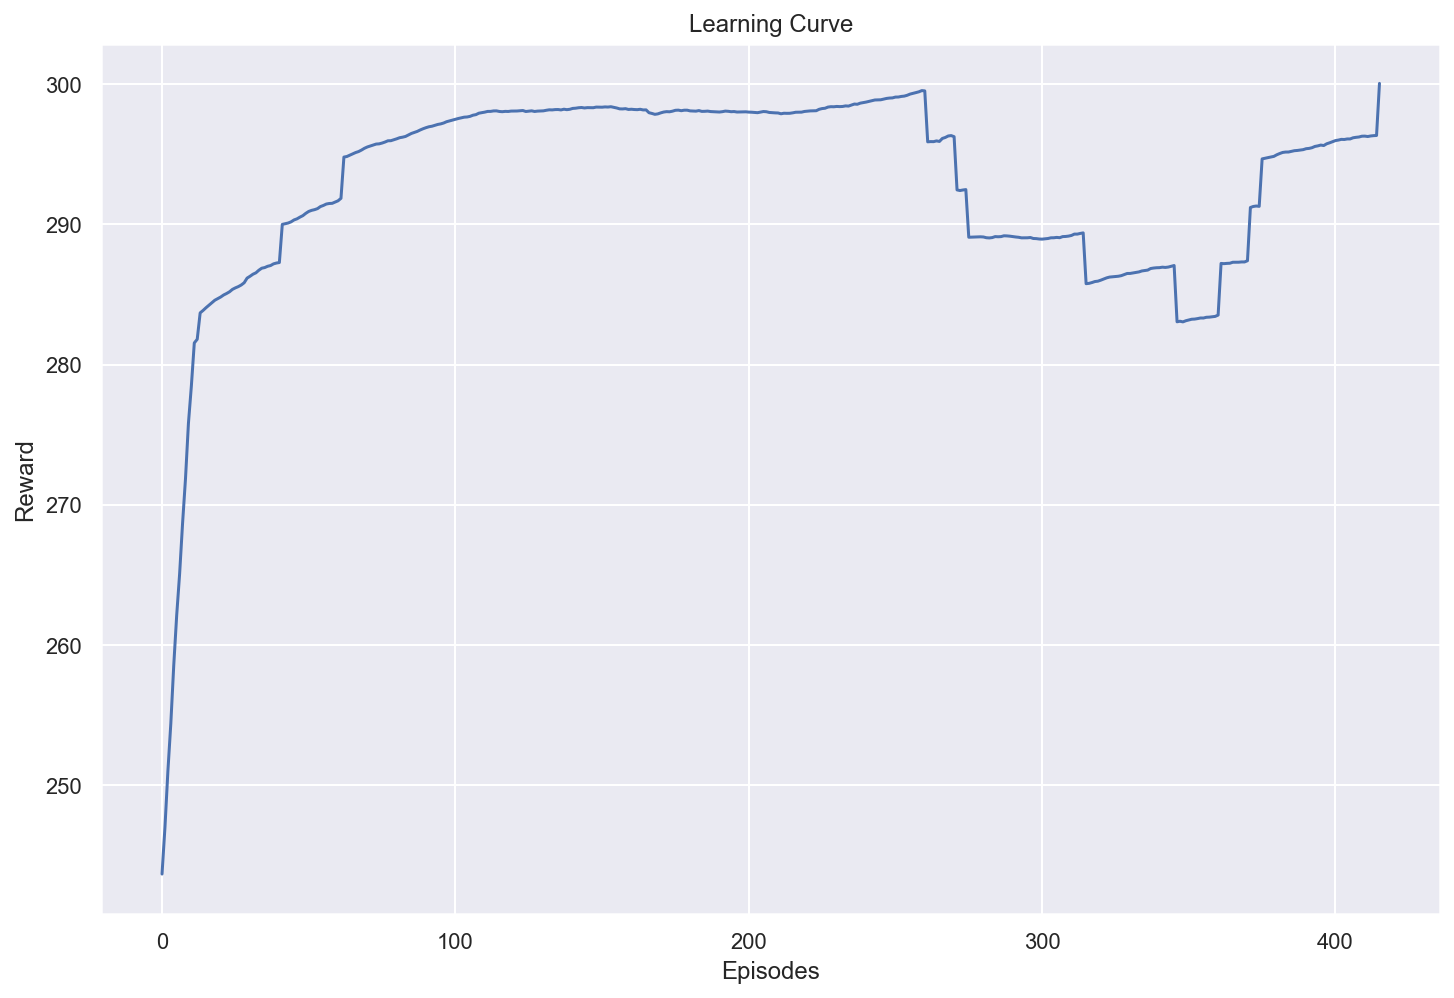

In [44]:


# something wrong with min , and something definitely wrong with max !!!!!!!!!!!!!!!!!!!!!!

import seaborn as sns

plt.figure(figsize=(12,8))

# Plot

sns.set()

ax = sns.lineplot(data=rolling_data.RUNNING_AVG)

# ax.fill_between(rolling_data.index, rolling_min.iloc[:, 0], rolling_max.iloc[:, 0], alpha=0.2)

ax.set_title('Learning Curve')

ax.set_ylabel('Reward')

ax.set_xlabel('Episodes'); 
    

In [ ]:

# print(RUNNING_AVG)

# print(RUNNING_MAX)

# print(RUNNING_MIN)


    # Plot
    sns.set()
    ax = sns.lineplot(data=rolling_data)
    ax.fill_between(rolling_average.index, rolling_min.iloc[:, 0], rolling_max.iloc[:, 0], alpha=0.2)
    ax.set_title('Learning Curve')
    ax.set_ylabel('Reward')
    ax.set_xlabel('Episodes')
    
    
